In [7]:
from preprocessing import *
import torch.optim as optim
from tqdm import tqdm
from mindiffusion.ddpm import DDPM
from mindiffusion.unet import NaiveUnet
device = torch.device('cuda:3')
train_data = train_data.to(device)

In [13]:
ddpm = DDPM(eps_model=NaiveUnet(1, 1, n_feat=128), betas=(1e-4, 0.02), n_T=1000)
ddpm.to(device)

DDPM(
  (eps_model): NaiveUnet(
    (init_conv): Conv3(
      (main): Sequential(
        (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): ReLU()
      )
      (conv): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(8, 128, eps=1e-05, affine=True)
        (5): ReLU()
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): Conv3(
          (main): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): GroupNorm(8, 128, eps=1e-05, affine=True)
            (2): ReLU()
          )
          (conv): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [12]:
optim = torch.optim.Adam(ddpm.parameters(), lr=1e-5)

In [15]:
def train_ddpm(n_epoch):
    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        ddpm.train()

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, _ in pbar:
            optim.zero_grad()
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        ddpm.eval()
        with torch.no_grad():
            xh = ddpm.sample(8, (3, 32, 32), device)
            xset = torch.cat([xh, x[:8]], dim=0)
            grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
            save_image(grid, f"./contents/ddpm_sample_cifar{i}.png")

            # save model
            torch.save(ddpm.state_dict(), f"./ddpm_cifar.pth")
            


In [48]:
def train_1_ep_ddpm(num_epoch, optim):

    print(f"Epoch {num_epoch} : ")
    ddpm.train()

    loss_ema = None
    for i in tqdm(range(train_data.shape[0])):
        optim.zero_grad()
        loss = ddpm(train_data[i])
        loss.backward()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
        optim.step()
    print('loss',loss_ema)
    if num_epoch%20 == 1:
        ddpm.eval()
        with torch.no_grad():
            xh = ddpm.sample(3, (1, 64, 64), device)
            print(xh.shape)
            tensor_to_picture(xh[0].detach().cpu().numpy()[0])
            tensor_to_picture(xh[1].detach().cpu().numpy()[0])
            tensor_to_picture(xh[2].detach().cpu().numpy()[0])

    # save model
    torch.save(ddpm.state_dict(), f"./ddpm1000.pth")

In [43]:
def train_ddpm(epoch, lr, lr_decay, reg):
    for i in range(epoch):
        
        optim = torch.optim.SGD(ddpm.parameters(), lr=lr*lr_decay**i, momentum=0.9, weight_decay=reg)
        train_1_ep_ddpm(i, optim)

Epoch 0 : 


100%|██████████| 400/400 [00:18<00:00, 21.10it/s]


loss 0.05877919850103945
Epoch 1 : 


100%|██████████| 400/400 [00:19<00:00, 20.97it/s]


loss 0.09992093266907924
torch.Size([3, 1, 64, 64])


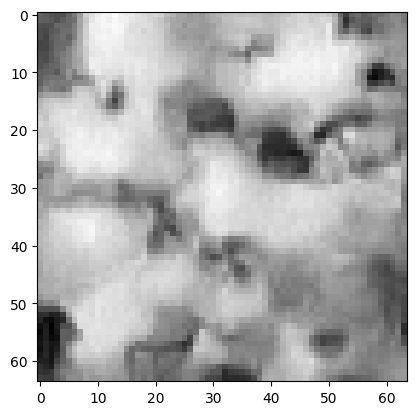

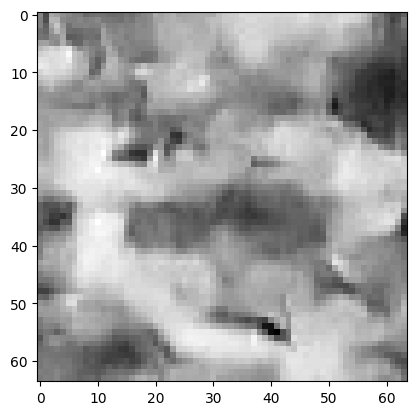

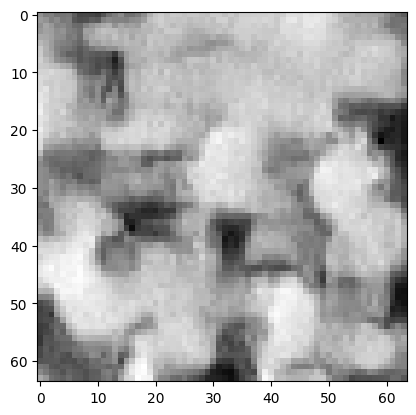

Epoch 2 : 


100%|██████████| 400/400 [00:18<00:00, 21.97it/s]


loss 0.05742492111311086
Epoch 3 : 


100%|██████████| 400/400 [00:19<00:00, 20.24it/s]


loss 0.09822406181266265
Epoch 4 : 


100%|██████████| 400/400 [00:19<00:00, 20.84it/s]


loss 0.05603314064716481
Epoch 5 : 


100%|██████████| 400/400 [00:19<00:00, 20.94it/s]


loss 0.07932284627006106
Epoch 6 : 


100%|██████████| 400/400 [00:18<00:00, 21.40it/s]


loss 0.05895470659282146
Epoch 7 : 


100%|██████████| 400/400 [00:18<00:00, 21.15it/s]


loss 0.09937645662579883
Epoch 8 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.06229782737515097
Epoch 9 : 


100%|██████████| 400/400 [00:18<00:00, 21.45it/s]


loss 0.0429408182710784
Epoch 10 : 


100%|██████████| 400/400 [00:19<00:00, 20.72it/s]


loss 0.07668061627061956
Epoch 11 : 


100%|██████████| 400/400 [00:18<00:00, 21.39it/s]


loss 0.04741983928027176
Epoch 12 : 


100%|██████████| 400/400 [00:18<00:00, 21.61it/s]


loss 0.045844068295617046
Epoch 13 : 


100%|██████████| 400/400 [00:18<00:00, 21.14it/s]


loss 0.12022445427544043
Epoch 14 : 


100%|██████████| 400/400 [00:19<00:00, 21.03it/s]


loss 0.07504738722970929
Epoch 15 : 


100%|██████████| 400/400 [00:19<00:00, 20.85it/s]


loss 0.04821761149353827
Epoch 16 : 


100%|██████████| 400/400 [00:19<00:00, 20.54it/s]


loss 0.06066175612890808
Epoch 17 : 


100%|██████████| 400/400 [00:19<00:00, 20.78it/s]


loss 0.04309398624832097
Epoch 18 : 


100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


loss 0.06881226521200591
Epoch 19 : 


100%|██████████| 400/400 [00:19<00:00, 20.38it/s]


loss 0.061641007437015734
Epoch 20 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.03923643080407894
Epoch 21 : 


100%|██████████| 400/400 [00:18<00:00, 21.58it/s]


loss 0.08028779567934867
torch.Size([3, 1, 64, 64])


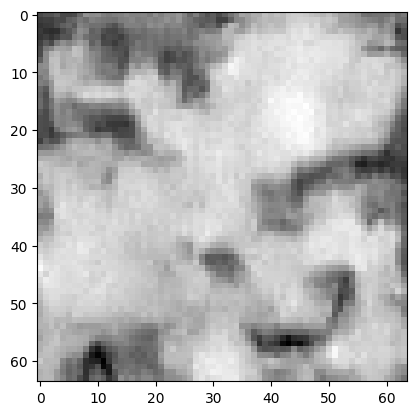

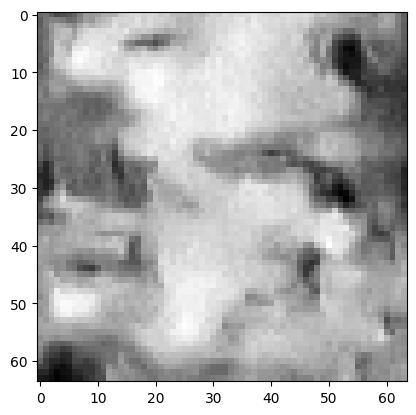

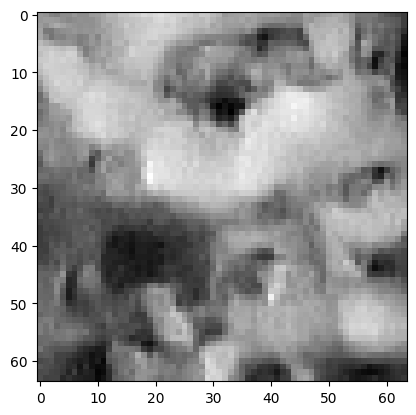

Epoch 22 : 


100%|██████████| 400/400 [00:19<00:00, 20.92it/s]


loss 0.056708228336652955
Epoch 23 : 


100%|██████████| 400/400 [00:18<00:00, 21.40it/s]


loss 0.13753498059685654
Epoch 24 : 


100%|██████████| 400/400 [00:18<00:00, 21.14it/s]


loss 0.0877144389574207
Epoch 25 : 


100%|██████████| 400/400 [00:19<00:00, 20.17it/s]


loss 0.04522386574181392
Epoch 26 : 


100%|██████████| 400/400 [00:18<00:00, 21.23it/s]


loss 0.09646062313112186
Epoch 27 : 


100%|██████████| 400/400 [00:18<00:00, 22.16it/s]


loss 0.05188759317760491
Epoch 28 : 


100%|██████████| 400/400 [00:18<00:00, 21.41it/s]


loss 0.07973784312153084
Epoch 29 : 


100%|██████████| 400/400 [00:18<00:00, 21.63it/s]


loss 0.0442081066867951
Epoch 30 : 


100%|██████████| 400/400 [00:18<00:00, 21.62it/s]


loss 0.06746998873072059
Epoch 31 : 


100%|██████████| 400/400 [00:18<00:00, 21.81it/s]


loss 0.08650275219860797
Epoch 32 : 


100%|██████████| 400/400 [00:17<00:00, 22.38it/s]


loss 0.08279581408287082
Epoch 33 : 


100%|██████████| 400/400 [00:19<00:00, 21.02it/s]


loss 0.03927417168983156
Epoch 34 : 


100%|██████████| 400/400 [00:18<00:00, 21.42it/s]


loss 0.0741301390010282
Epoch 35 : 


100%|██████████| 400/400 [00:18<00:00, 21.08it/s]


loss 0.09006368883109846
Epoch 36 : 


100%|██████████| 400/400 [00:17<00:00, 22.27it/s]


loss 0.0902656790172542
Epoch 37 : 


100%|██████████| 400/400 [00:18<00:00, 21.81it/s]


loss 0.03960342725817327
Epoch 38 : 


100%|██████████| 400/400 [00:18<00:00, 21.51it/s]


loss 0.042214701172574726
Epoch 39 : 


100%|██████████| 400/400 [00:18<00:00, 21.63it/s]


loss 0.05156038730349048
Epoch 40 : 


100%|██████████| 400/400 [00:18<00:00, 22.02it/s]


loss 0.030155848195722135
Epoch 41 : 


100%|██████████| 400/400 [00:18<00:00, 22.22it/s]


loss 0.0675868892647492
torch.Size([3, 1, 64, 64])


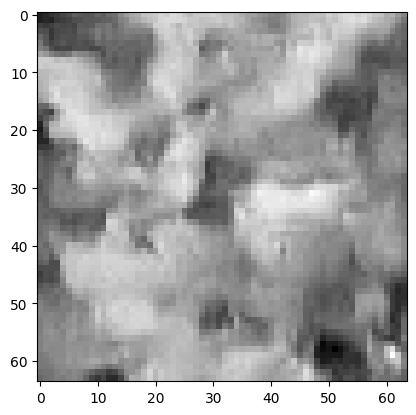

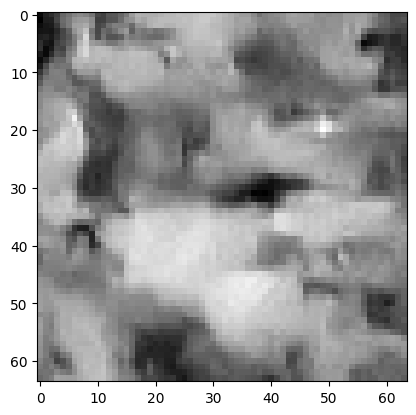

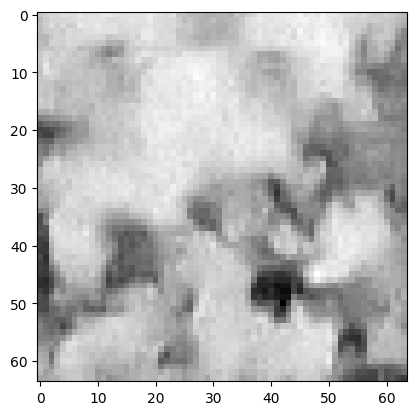

Epoch 42 : 


100%|██████████| 400/400 [00:17<00:00, 22.35it/s]


loss 0.09493559250983635
Epoch 43 : 


100%|██████████| 400/400 [00:17<00:00, 22.44it/s]


loss 0.09113947944515687
Epoch 44 : 


100%|██████████| 400/400 [00:18<00:00, 21.18it/s]


loss 0.055267181433471056
Epoch 45 : 


100%|██████████| 400/400 [00:19<00:00, 20.55it/s]


loss 0.09495586970737548
Epoch 46 : 


100%|██████████| 400/400 [00:19<00:00, 20.59it/s]


loss 0.03136449513497606
Epoch 47 : 


100%|██████████| 400/400 [00:19<00:00, 20.05it/s]


loss 0.07558262534387507
Epoch 48 : 


100%|██████████| 400/400 [00:15<00:00, 26.04it/s]


loss 0.12177323756443717
Epoch 49 : 


100%|██████████| 400/400 [00:13<00:00, 30.46it/s]


loss 0.08586286541431401
Epoch 50 : 


100%|██████████| 400/400 [00:18<00:00, 21.94it/s]


loss 0.08956264465100272
Epoch 51 : 


100%|██████████| 400/400 [00:17<00:00, 23.41it/s]


loss 0.1315588260606812
Epoch 52 : 


100%|██████████| 400/400 [00:17<00:00, 22.86it/s]


loss 0.03710985396901646
Epoch 53 : 


100%|██████████| 400/400 [00:15<00:00, 25.32it/s]


loss 0.10879569039676648
Epoch 54 : 


100%|██████████| 400/400 [00:17<00:00, 22.95it/s]


loss 0.0782939311421721
Epoch 55 : 


100%|██████████| 400/400 [00:18<00:00, 21.74it/s]


loss 0.031226508995761966
Epoch 56 : 


100%|██████████| 400/400 [00:17<00:00, 22.47it/s]


loss 0.04574714865320367
Epoch 57 : 


100%|██████████| 400/400 [00:17<00:00, 22.85it/s]


loss 0.05078390311363992
Epoch 58 : 


100%|██████████| 400/400 [00:18<00:00, 22.18it/s]


loss 0.09453980348641051
Epoch 59 : 


100%|██████████| 400/400 [00:18<00:00, 21.29it/s]


loss 0.039267439204003544
Epoch 60 : 


100%|██████████| 400/400 [00:16<00:00, 23.69it/s]


loss 0.06930182487270546
Epoch 61 : 


100%|██████████| 400/400 [00:18<00:00, 22.12it/s]


loss 0.08291537291835466
torch.Size([3, 1, 64, 64])


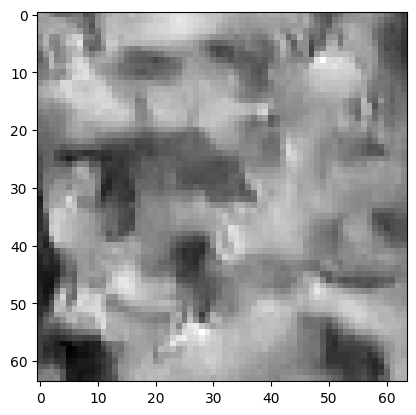

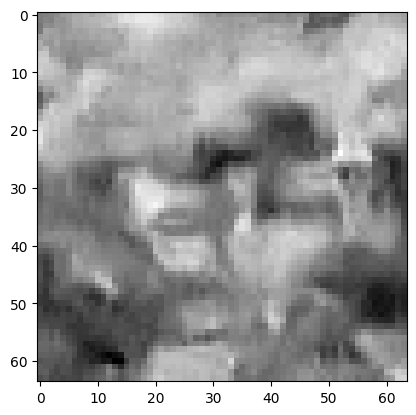

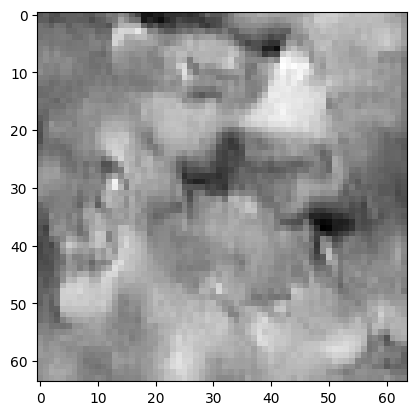

Epoch 62 : 


100%|██████████| 400/400 [00:19<00:00, 20.28it/s]


loss 0.061602812429205546
Epoch 63 : 


100%|██████████| 400/400 [00:19<00:00, 20.97it/s]


loss 0.07798269860741514
Epoch 64 : 


100%|██████████| 400/400 [00:17<00:00, 22.31it/s]


loss 0.0785945854401352
Epoch 65 : 


100%|██████████| 400/400 [00:18<00:00, 22.03it/s]


loss 0.05733465326793482
Epoch 66 : 


100%|██████████| 400/400 [00:18<00:00, 22.21it/s]


loss 0.0323627412306635
Epoch 67 : 


100%|██████████| 400/400 [00:18<00:00, 21.19it/s]


loss 0.06800432034350769
Epoch 68 : 


100%|██████████| 400/400 [00:19<00:00, 20.90it/s]


loss 0.1438786865714217
Epoch 69 : 


100%|██████████| 400/400 [00:18<00:00, 22.15it/s]


loss 0.08348803385733028
Epoch 70 : 


100%|██████████| 400/400 [00:18<00:00, 21.76it/s]


loss 0.09491463614777135
Epoch 71 : 


100%|██████████| 400/400 [00:18<00:00, 21.56it/s]


loss 0.05283287868973684
Epoch 72 : 


100%|██████████| 400/400 [00:19<00:00, 20.97it/s]


loss 0.050264989739643044
Epoch 73 : 


100%|██████████| 400/400 [00:18<00:00, 21.75it/s]


loss 0.09658653430478123
Epoch 74 : 


100%|██████████| 400/400 [00:18<00:00, 21.80it/s]


loss 0.0551339739416684
Epoch 75 : 


100%|██████████| 400/400 [00:18<00:00, 21.45it/s]


loss 0.06695037033399978
Epoch 76 : 


100%|██████████| 400/400 [00:18<00:00, 22.14it/s]


loss 0.11920967057076624
Epoch 77 : 


100%|██████████| 400/400 [00:19<00:00, 20.87it/s]


loss 0.10454093782330948
Epoch 78 : 


100%|██████████| 400/400 [00:17<00:00, 22.23it/s]


loss 0.036687635213802985
Epoch 79 : 


100%|██████████| 400/400 [00:18<00:00, 21.11it/s]


loss 0.041722109863596764
Epoch 80 : 


100%|██████████| 400/400 [00:17<00:00, 23.44it/s]


loss 0.06710055240200524
Epoch 81 : 


100%|██████████| 400/400 [00:18<00:00, 21.37it/s]


loss 0.08727992263775214
torch.Size([3, 1, 64, 64])


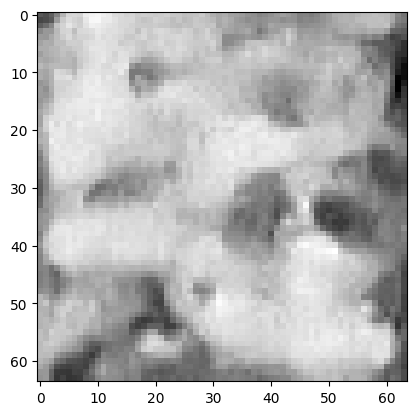

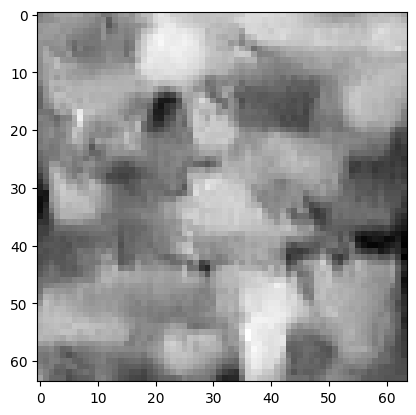

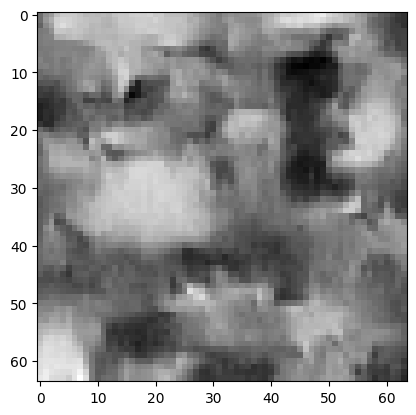

Epoch 82 : 


100%|██████████| 400/400 [00:15<00:00, 25.78it/s]


loss 0.07550260952295984
Epoch 83 : 


100%|██████████| 400/400 [00:15<00:00, 25.89it/s]


loss 0.05351569607299676
Epoch 84 : 


100%|██████████| 400/400 [00:16<00:00, 24.41it/s]


loss 0.07753712324424772
Epoch 85 : 


100%|██████████| 400/400 [00:18<00:00, 21.77it/s]


loss 0.0565711077135218
Epoch 86 : 


100%|██████████| 400/400 [00:18<00:00, 22.06it/s]


loss 0.08262271297483918
Epoch 87 : 


100%|██████████| 400/400 [00:18<00:00, 22.05it/s]


loss 0.05406172320812652
Epoch 88 : 


100%|██████████| 400/400 [00:15<00:00, 25.50it/s]


loss 0.08403796018853475
Epoch 89 : 


100%|██████████| 400/400 [00:18<00:00, 21.97it/s]


loss 0.03759730884994615
Epoch 90 : 


100%|██████████| 400/400 [00:18<00:00, 22.08it/s]


loss 0.0701365698551763
Epoch 91 : 


100%|██████████| 400/400 [00:18<00:00, 21.82it/s]


loss 0.03548889433116993
Epoch 92 : 


100%|██████████| 400/400 [00:19<00:00, 20.98it/s]


loss 0.0804715002253629
Epoch 93 : 


100%|██████████| 400/400 [00:17<00:00, 23.29it/s]


loss 0.03575452613735299
Epoch 94 : 


100%|██████████| 400/400 [00:18<00:00, 21.28it/s]


loss 0.09940515123172018
Epoch 95 : 


100%|██████████| 400/400 [00:18<00:00, 22.04it/s]


loss 0.061018127962702125
Epoch 96 : 


100%|██████████| 400/400 [00:17<00:00, 23.00it/s]


loss 0.06261852042512016
Epoch 97 : 


100%|██████████| 400/400 [00:18<00:00, 21.33it/s]


loss 0.051507401812010155
Epoch 98 : 


100%|██████████| 400/400 [00:18<00:00, 21.40it/s]


loss 0.08267044816656798
Epoch 99 : 


100%|██████████| 400/400 [00:17<00:00, 23.51it/s]


loss 0.05318140777532927


In [45]:
train_ddpm(100, 0.00001, 1, 0)

Epoch 0 : 


100%|██████████| 400/400 [00:18<00:00, 21.62it/s]


loss 0.1620960581032615
Epoch 1 : 


100%|██████████| 400/400 [00:18<00:00, 21.46it/s]


loss 0.11676539380923809
torch.Size([3, 1, 64, 64])


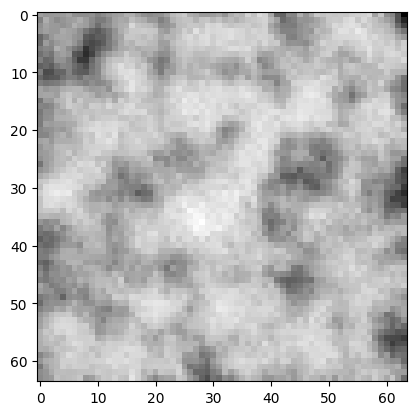

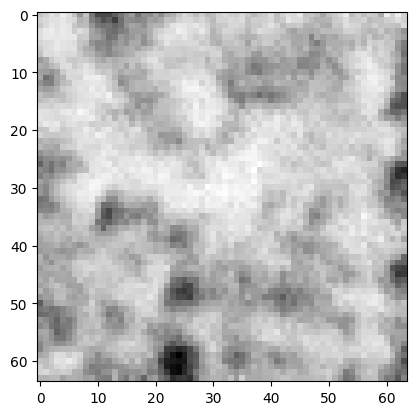

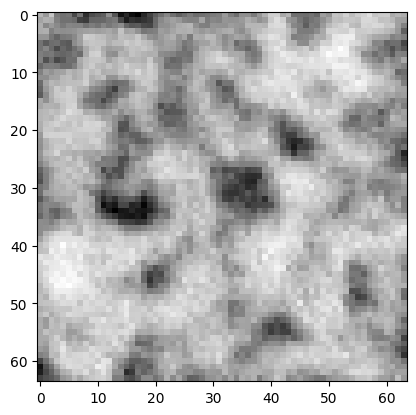

Epoch 2 : 


100%|██████████| 400/400 [00:17<00:00, 22.87it/s]


loss 0.10755681435237052
Epoch 3 : 


100%|██████████| 400/400 [00:18<00:00, 21.93it/s]


loss 0.10071689635391355
Epoch 4 : 


100%|██████████| 400/400 [00:18<00:00, 21.62it/s]


loss 0.0711330787468455
Epoch 5 : 


100%|██████████| 400/400 [00:19<00:00, 20.61it/s]


loss 0.06424297385643973
Epoch 6 : 


100%|██████████| 400/400 [00:19<00:00, 21.02it/s]


loss 0.15280013933950154
Epoch 7 : 


100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


loss 0.11945795494306105
Epoch 8 : 


100%|██████████| 400/400 [00:18<00:00, 21.58it/s]


loss 0.08692316608257838
Epoch 9 : 


100%|██████████| 400/400 [00:19<00:00, 20.65it/s]


loss 0.09762944886848417
Epoch 10 : 


100%|██████████| 400/400 [00:19<00:00, 20.30it/s]


loss 0.053791644580331546
Epoch 11 : 


100%|██████████| 400/400 [00:19<00:00, 20.90it/s]


loss 0.03930103407255377
Epoch 12 : 


100%|██████████| 400/400 [00:18<00:00, 21.32it/s]


loss 0.09888742380239797
Epoch 13 : 


100%|██████████| 400/400 [00:18<00:00, 21.78it/s]


loss 0.09344760505189836
Epoch 14 : 


100%|██████████| 400/400 [00:18<00:00, 22.09it/s]


loss 0.08549065115929808
Epoch 15 : 


100%|██████████| 400/400 [00:18<00:00, 21.56it/s]


loss 0.08705391532957697
Epoch 16 : 


100%|██████████| 400/400 [00:18<00:00, 21.32it/s]


loss 0.13403035155544885
Epoch 17 : 


100%|██████████| 400/400 [00:18<00:00, 21.51it/s]


loss 0.11774340997149053
Epoch 18 : 


100%|██████████| 400/400 [00:18<00:00, 21.43it/s]


loss 0.05608739502869991
Epoch 19 : 


100%|██████████| 400/400 [00:18<00:00, 21.55it/s]


loss 0.12464044255752979
Epoch 20 : 


100%|██████████| 400/400 [00:19<00:00, 20.58it/s]


loss 0.057118752527333484
Epoch 21 : 


100%|██████████| 400/400 [00:19<00:00, 20.55it/s]


loss 0.09797807091567755
torch.Size([3, 1, 64, 64])


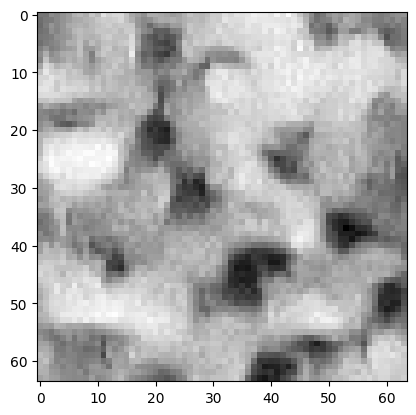

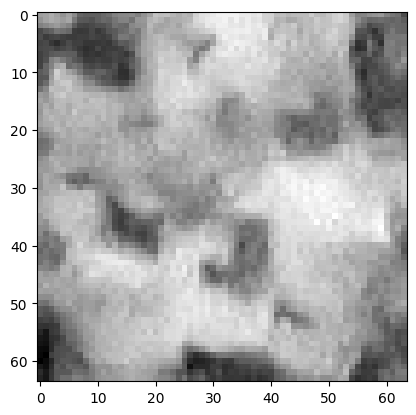

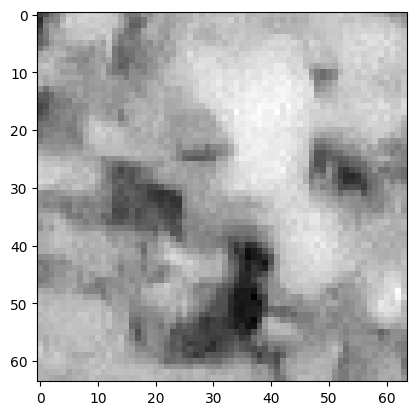

Epoch 22 : 


100%|██████████| 400/400 [00:19<00:00, 20.45it/s]


loss 0.09777254147721594
Epoch 23 : 


100%|██████████| 400/400 [00:19<00:00, 20.86it/s]


loss 0.06678306764930349
Epoch 24 : 


100%|██████████| 400/400 [00:18<00:00, 21.57it/s]


loss 0.07425952896313294
Epoch 25 : 


100%|██████████| 400/400 [00:18<00:00, 21.73it/s]


loss 0.05060630948962258
Epoch 26 : 


100%|██████████| 400/400 [00:18<00:00, 21.65it/s]


loss 0.07032714199863589
Epoch 27 : 


100%|██████████| 400/400 [00:19<00:00, 20.43it/s]


loss 0.05148485598712684
Epoch 28 : 


100%|██████████| 400/400 [00:18<00:00, 21.31it/s]


loss 0.1532103968389155
Epoch 29 : 


100%|██████████| 400/400 [00:18<00:00, 21.68it/s]


loss 0.12802105067646358
Epoch 30 : 


100%|██████████| 400/400 [00:18<00:00, 21.77it/s]


loss 0.09810597320534607
Epoch 31 : 


100%|██████████| 400/400 [00:18<00:00, 21.76it/s]


loss 0.1334801224916308
Epoch 32 : 


100%|██████████| 400/400 [00:18<00:00, 21.53it/s]


loss 0.04025113912501902
Epoch 33 : 


100%|██████████| 400/400 [00:18<00:00, 21.24it/s]


loss 0.04458347395496586
Epoch 34 : 


100%|██████████| 400/400 [00:18<00:00, 21.91it/s]


loss 0.06735792947557256
Epoch 35 : 


100%|██████████| 400/400 [00:18<00:00, 22.10it/s]


loss 0.0729615199048542
Epoch 36 : 


100%|██████████| 400/400 [00:18<00:00, 21.70it/s]


loss 0.2352289782613073
Epoch 37 : 


100%|██████████| 400/400 [00:18<00:00, 21.57it/s]


loss 0.10055494734664407
Epoch 38 : 


100%|██████████| 400/400 [00:18<00:00, 21.65it/s]


loss 0.1296873587906882
Epoch 39 : 


100%|██████████| 400/400 [00:18<00:00, 21.74it/s]


loss 0.16031310126573398
Epoch 40 : 


100%|██████████| 400/400 [00:19<00:00, 20.90it/s]


loss 0.08118545349649829
Epoch 41 : 


100%|██████████| 400/400 [00:18<00:00, 21.71it/s]


loss 0.061117312529232505
torch.Size([3, 1, 64, 64])


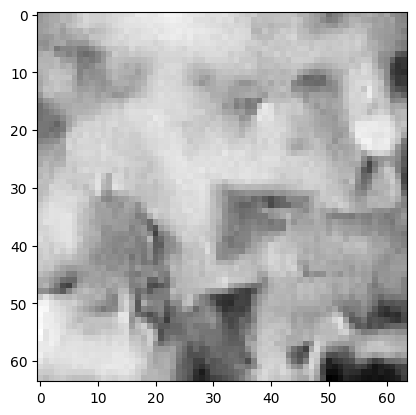

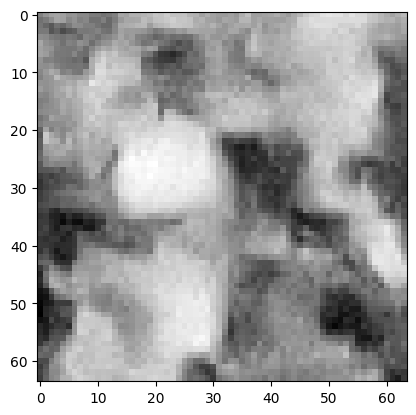

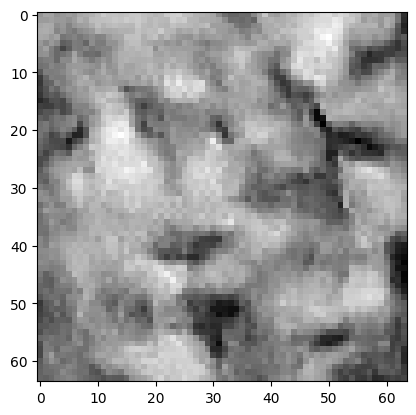

Epoch 42 : 


100%|██████████| 400/400 [00:18<00:00, 21.59it/s]


loss 0.08227567512939331
Epoch 43 : 


100%|██████████| 400/400 [00:18<00:00, 21.58it/s]


loss 0.07061334811542468
Epoch 44 : 


100%|██████████| 400/400 [00:18<00:00, 21.16it/s]


loss 0.04208511133224951
Epoch 45 : 


100%|██████████| 400/400 [00:19<00:00, 21.05it/s]


loss 0.025668325277070303
Epoch 46 : 


100%|██████████| 400/400 [00:18<00:00, 21.56it/s]


loss 0.08015001475912421
Epoch 47 : 


100%|██████████| 400/400 [00:18<00:00, 21.24it/s]


loss 0.11979631531960719
Epoch 48 : 


100%|██████████| 400/400 [00:18<00:00, 21.53it/s]


loss 0.06054099904906641
Epoch 49 : 


100%|██████████| 400/400 [00:18<00:00, 21.73it/s]


loss 0.04549014874705673
Epoch 50 : 


100%|██████████| 400/400 [00:18<00:00, 21.96it/s]


loss 0.06468540501017103
Epoch 51 : 


100%|██████████| 400/400 [00:18<00:00, 21.51it/s]


loss 0.06307786226190401
Epoch 52 : 


100%|██████████| 400/400 [00:18<00:00, 21.10it/s]


loss 0.0981055244552512
Epoch 53 : 


100%|██████████| 400/400 [00:18<00:00, 22.15it/s]


loss 0.09270617883818327
Epoch 54 : 


100%|██████████| 400/400 [00:18<00:00, 22.08it/s]


loss 0.05864933907791582
Epoch 55 : 


100%|██████████| 400/400 [00:18<00:00, 21.53it/s]


loss 0.14707938779084123
Epoch 56 : 


100%|██████████| 400/400 [00:18<00:00, 21.27it/s]


loss 0.1323485745327418
Epoch 57 : 


100%|██████████| 400/400 [00:18<00:00, 21.97it/s]


loss 0.046690845490377074
Epoch 58 : 


100%|██████████| 400/400 [00:18<00:00, 21.56it/s]


loss 0.08221810350276698
Epoch 59 : 


100%|██████████| 400/400 [00:18<00:00, 21.13it/s]


loss 0.04906782699006161
Epoch 60 : 


100%|██████████| 400/400 [00:18<00:00, 21.52it/s]


loss 0.0977323419145287
Epoch 61 : 


100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


loss 0.07920317268108182
torch.Size([3, 1, 64, 64])


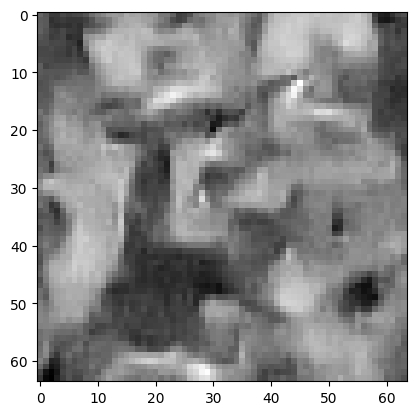

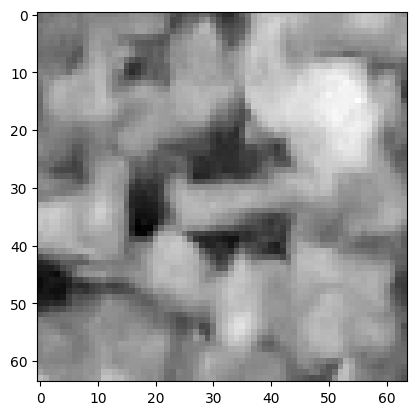

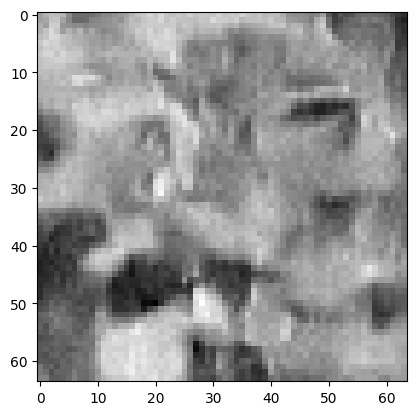

Epoch 62 : 


100%|██████████| 400/400 [00:18<00:00, 21.06it/s]


loss 0.08223102147186936
Epoch 63 : 


100%|██████████| 400/400 [00:18<00:00, 21.69it/s]


loss 0.10449919736997149
Epoch 64 : 


100%|██████████| 400/400 [00:18<00:00, 21.27it/s]


loss 0.05691858778938088
Epoch 65 : 


100%|██████████| 400/400 [00:18<00:00, 21.56it/s]


loss 0.03761629281272018
Epoch 66 : 


100%|██████████| 400/400 [00:18<00:00, 21.83it/s]


loss 0.11697366411892329
Epoch 67 : 


100%|██████████| 400/400 [00:18<00:00, 21.58it/s]


loss 0.08378719290914173
Epoch 68 : 


100%|██████████| 400/400 [00:18<00:00, 21.42it/s]


loss 0.06384303508849794
Epoch 69 : 


100%|██████████| 400/400 [00:19<00:00, 20.88it/s]


loss 0.10781373755280106
Epoch 70 : 


100%|██████████| 400/400 [00:19<00:00, 20.64it/s]


loss 0.051328783106750424
Epoch 71 : 


100%|██████████| 400/400 [00:18<00:00, 21.51it/s]


loss 0.09728950707599975
Epoch 72 : 


100%|██████████| 400/400 [00:18<00:00, 22.09it/s]


loss 0.07226811366307968
Epoch 73 : 


100%|██████████| 400/400 [00:18<00:00, 21.33it/s]


loss 0.06489792533574129
Epoch 74 : 


100%|██████████| 400/400 [00:18<00:00, 21.18it/s]


loss 0.030408649013656905
Epoch 75 : 


100%|██████████| 400/400 [00:18<00:00, 21.41it/s]


loss 0.17343551567418847
Epoch 76 : 


100%|██████████| 400/400 [00:18<00:00, 21.89it/s]


loss 0.07420381395447698
Epoch 77 : 


100%|██████████| 400/400 [00:19<00:00, 20.76it/s]


loss 0.08268620693873185
Epoch 78 : 


100%|██████████| 400/400 [00:19<00:00, 20.52it/s]


loss 0.06155348820057553
Epoch 79 : 


100%|██████████| 400/400 [00:19<00:00, 20.02it/s]


loss 0.07101047798388449
Epoch 80 : 


100%|██████████| 400/400 [00:18<00:00, 22.00it/s]


loss 0.06701625780928203
Epoch 81 : 


100%|██████████| 400/400 [00:19<00:00, 20.99it/s]


loss 0.06857417519573891
torch.Size([3, 1, 64, 64])


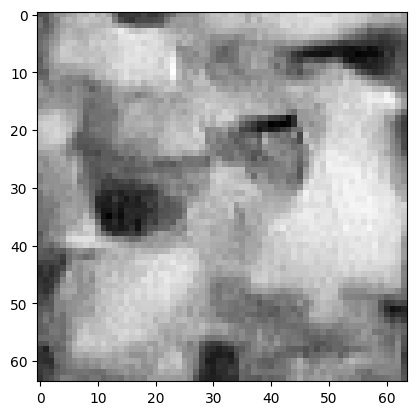

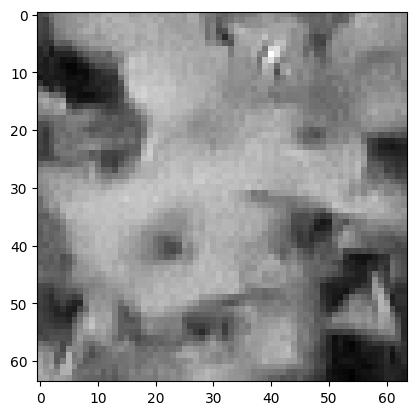

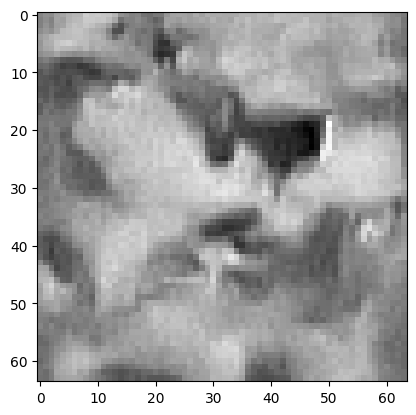

Epoch 82 : 


100%|██████████| 400/400 [00:18<00:00, 21.63it/s]


loss 0.10350902014958285
Epoch 83 : 


100%|██████████| 400/400 [00:18<00:00, 22.06it/s]


loss 0.05268074554161201
Epoch 84 : 


100%|██████████| 400/400 [00:18<00:00, 22.11it/s]


loss 0.04989503961394911
Epoch 85 : 


100%|██████████| 400/400 [00:17<00:00, 22.53it/s]


loss 0.03162542399229232
Epoch 86 : 


100%|██████████| 400/400 [00:18<00:00, 21.68it/s]


loss 0.07162067409930314
Epoch 87 : 


100%|██████████| 400/400 [00:19<00:00, 21.02it/s]


loss 0.09130204230386449
Epoch 88 : 


100%|██████████| 400/400 [00:18<00:00, 21.64it/s]


loss 0.05022682848399392
Epoch 89 : 


100%|██████████| 400/400 [00:18<00:00, 21.57it/s]


loss 0.09070577568851054
Epoch 90 : 


100%|██████████| 400/400 [00:19<00:00, 21.00it/s]


loss 0.12109410192131231
Epoch 91 : 


100%|██████████| 400/400 [00:18<00:00, 21.07it/s]


loss 0.07839984572537291
Epoch 92 : 


100%|██████████| 400/400 [00:18<00:00, 22.09it/s]


loss 0.045922354833849
Epoch 93 : 


100%|██████████| 400/400 [00:17<00:00, 23.35it/s]


loss 0.06040312068990079
Epoch 94 : 


100%|██████████| 400/400 [00:19<00:00, 20.96it/s]


loss 0.1300139086217248
Epoch 95 : 


100%|██████████| 400/400 [00:18<00:00, 21.62it/s]


loss 0.04087731903483747
Epoch 96 : 


100%|██████████| 400/400 [00:17<00:00, 22.31it/s]


loss 0.04400038829552531
Epoch 97 : 


100%|██████████| 400/400 [00:18<00:00, 21.36it/s]


loss 0.14258472016214863
Epoch 98 : 


100%|██████████| 400/400 [00:18<00:00, 21.99it/s]


loss 0.09646797307947179
Epoch 99 : 


100%|██████████| 400/400 [00:18<00:00, 21.29it/s]


loss 0.06434593135601244


In [46]:
train_ddpm(100, 0.01, 1, 0)

Epoch 0 : 


100%|██████████| 400/400 [00:18<00:00, 21.75it/s]


loss 0.10740734537809586
Epoch 1 : 


100%|██████████| 400/400 [00:19<00:00, 21.03it/s]


loss 0.1311444913385875
torch.Size([3, 1, 64, 64])


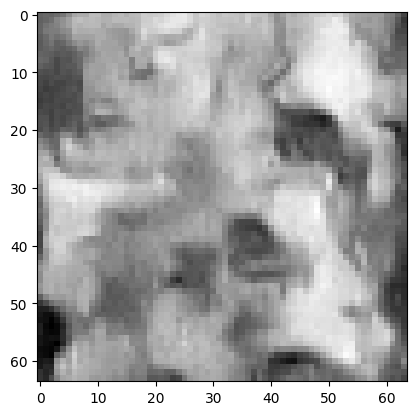

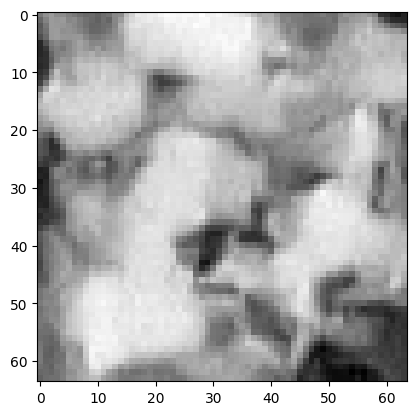

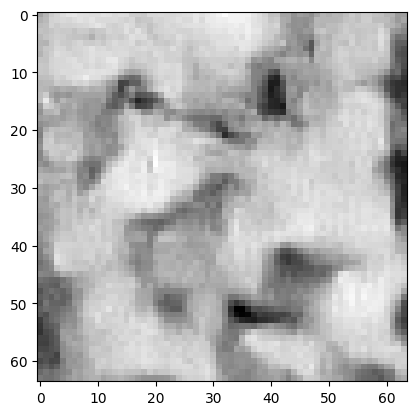

Epoch 2 : 


100%|██████████| 400/400 [00:18<00:00, 21.59it/s]


loss 0.047738318787772176
Epoch 3 : 


100%|██████████| 400/400 [00:18<00:00, 21.36it/s]


loss 0.06707786904558784
Epoch 4 : 


100%|██████████| 400/400 [00:18<00:00, 21.63it/s]


loss 0.09463284492052729
Epoch 5 : 


100%|██████████| 400/400 [00:18<00:00, 21.93it/s]


loss 0.05289906020960712
Epoch 6 : 


100%|██████████| 400/400 [00:19<00:00, 20.87it/s]


loss 0.11474202850688725
Epoch 7 : 


100%|██████████| 400/400 [00:18<00:00, 21.81it/s]


loss 0.04241065801764696
Epoch 8 : 


100%|██████████| 400/400 [00:18<00:00, 21.34it/s]


loss 0.09245646583726023
Epoch 9 : 


100%|██████████| 400/400 [00:18<00:00, 21.10it/s]


loss 0.053829783630558306
Epoch 10 : 


100%|██████████| 400/400 [00:18<00:00, 22.07it/s]


loss 0.12447482009867053
Epoch 11 : 


100%|██████████| 400/400 [00:18<00:00, 21.06it/s]


loss 0.15547485349971601
Epoch 12 : 


100%|██████████| 400/400 [00:18<00:00, 21.53it/s]


loss 0.1386127792402277
Epoch 13 : 


100%|██████████| 400/400 [00:18<00:00, 21.50it/s]


loss 0.0807038998565596
Epoch 14 : 


100%|██████████| 400/400 [00:18<00:00, 21.84it/s]


loss 0.0607067418545163
Epoch 15 : 


100%|██████████| 400/400 [00:17<00:00, 22.23it/s]


loss 0.10751367224634037
Epoch 16 : 


100%|██████████| 400/400 [00:18<00:00, 21.82it/s]


loss 0.17483521088094817
Epoch 17 : 


100%|██████████| 400/400 [00:18<00:00, 21.34it/s]


loss 0.05495795905003087
Epoch 18 : 


100%|██████████| 400/400 [00:18<00:00, 21.28it/s]


loss 0.06154004822055871
Epoch 19 : 


100%|██████████| 400/400 [00:18<00:00, 21.84it/s]


loss 0.06221883452510899
Epoch 20 : 


100%|██████████| 400/400 [00:18<00:00, 21.57it/s]


loss 0.10446632473607659
Epoch 21 : 


100%|██████████| 400/400 [00:18<00:00, 21.92it/s]


loss 0.05988520284571813
torch.Size([3, 1, 64, 64])


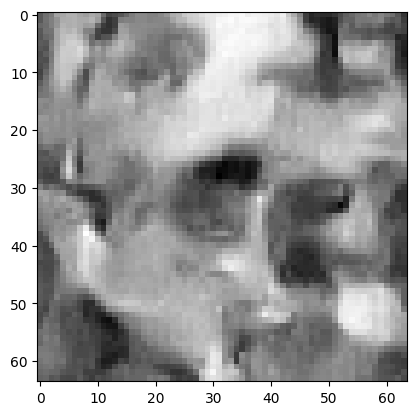

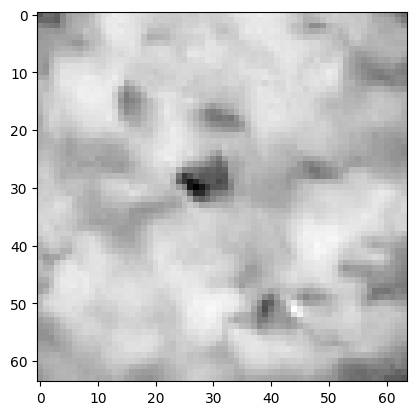

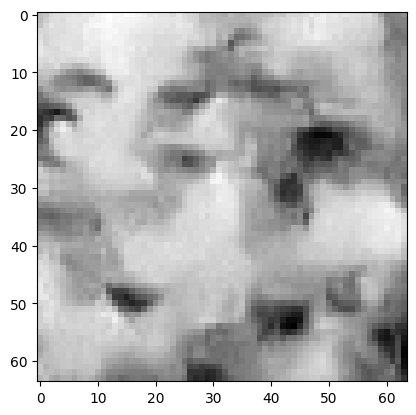

Epoch 22 : 


100%|██████████| 400/400 [00:18<00:00, 22.02it/s]


loss 0.14953246253817623
Epoch 23 : 


100%|██████████| 400/400 [00:18<00:00, 21.79it/s]


loss 0.10018839512819397
Epoch 24 : 


100%|██████████| 400/400 [00:17<00:00, 22.89it/s]


loss 0.0550928075443613
Epoch 25 : 


100%|██████████| 400/400 [00:19<00:00, 20.92it/s]


loss 0.09938769775591948
Epoch 26 : 


100%|██████████| 400/400 [00:18<00:00, 21.96it/s]


loss 0.06802324173330408
Epoch 27 : 


100%|██████████| 400/400 [00:18<00:00, 21.16it/s]


loss 0.03983629559375324
Epoch 28 : 


100%|██████████| 400/400 [00:18<00:00, 21.52it/s]


loss 0.06444823807429911
Epoch 29 : 


100%|██████████| 400/400 [00:18<00:00, 21.69it/s]


loss 0.07380401924855108
Epoch 30 : 


100%|██████████| 400/400 [00:18<00:00, 21.71it/s]


loss 0.06756204905483558
Epoch 31 : 


100%|██████████| 400/400 [00:17<00:00, 22.59it/s]


loss 0.06508965085227793
Epoch 32 : 


100%|██████████| 400/400 [00:18<00:00, 22.02it/s]


loss 0.11146556782669098
Epoch 33 : 


100%|██████████| 400/400 [00:18<00:00, 22.01it/s]


loss 0.03405823214447007
Epoch 34 : 


100%|██████████| 400/400 [00:18<00:00, 22.05it/s]


loss 0.04665121467411474
Epoch 35 : 


100%|██████████| 400/400 [00:18<00:00, 21.70it/s]


loss 0.12130485429599765
Epoch 36 : 


100%|██████████| 400/400 [00:18<00:00, 22.06it/s]


loss 0.09683996821643122
Epoch 37 : 


100%|██████████| 400/400 [00:18<00:00, 22.00it/s]


loss 0.10350803738289809
Epoch 38 : 


100%|██████████| 400/400 [00:18<00:00, 21.72it/s]


loss 0.08442439401462332
Epoch 39 : 


100%|██████████| 400/400 [00:18<00:00, 21.77it/s]


loss 0.06342125781589122
Epoch 40 : 


100%|██████████| 400/400 [00:18<00:00, 22.07it/s]


loss 0.09279189375164007
Epoch 41 : 


100%|██████████| 400/400 [00:18<00:00, 21.91it/s]


loss 0.05698117400290484
torch.Size([3, 1, 64, 64])


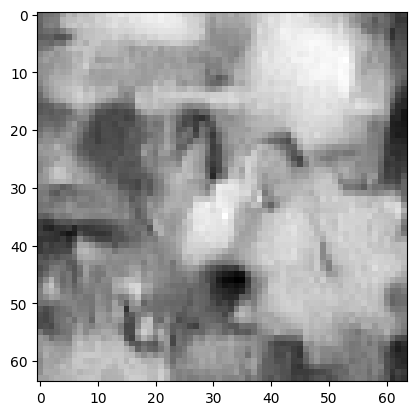

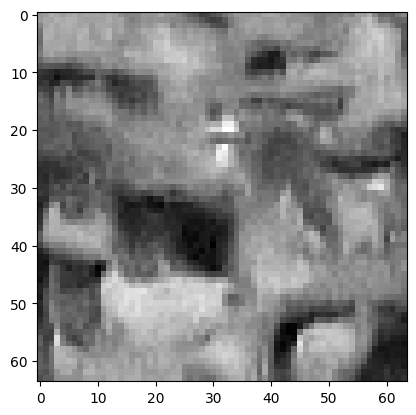

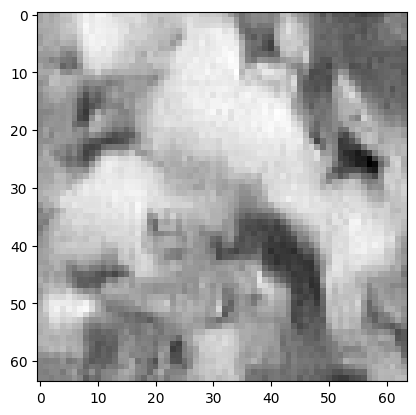

Epoch 42 : 


100%|██████████| 400/400 [00:18<00:00, 21.91it/s]


loss 0.05558665622137822
Epoch 43 : 


100%|██████████| 400/400 [00:18<00:00, 21.37it/s]


loss 0.0920432280225802
Epoch 44 : 


100%|██████████| 400/400 [00:18<00:00, 21.69it/s]


loss 0.025461868503908386
Epoch 45 : 


100%|██████████| 400/400 [00:18<00:00, 21.64it/s]


loss 0.05693171880451866
Epoch 46 : 


100%|██████████| 400/400 [00:18<00:00, 21.68it/s]


loss 0.08339464456474503
Epoch 47 : 


100%|██████████| 400/400 [00:18<00:00, 22.02it/s]


loss 0.09574259314246956
Epoch 48 : 


100%|██████████| 400/400 [00:18<00:00, 22.20it/s]


loss 0.07724891690273349
Epoch 49 : 


100%|██████████| 400/400 [00:17<00:00, 22.25it/s]


loss 0.08802850416503638
Epoch 50 : 


100%|██████████| 400/400 [00:18<00:00, 21.69it/s]


loss 0.04451823306068032
Epoch 51 : 


100%|██████████| 400/400 [00:18<00:00, 21.96it/s]


loss 0.046866212015054205
Epoch 52 : 


100%|██████████| 400/400 [00:18<00:00, 21.42it/s]


loss 0.08578210835070521
Epoch 53 : 


100%|██████████| 400/400 [00:18<00:00, 22.18it/s]


loss 0.06876048785489373
Epoch 54 : 


100%|██████████| 400/400 [00:17<00:00, 22.72it/s]


loss 0.09012260801726085
Epoch 55 : 


100%|██████████| 400/400 [00:18<00:00, 22.16it/s]


loss 0.04914014880053668
Epoch 56 : 


100%|██████████| 400/400 [00:18<00:00, 22.16it/s]


loss 0.06511030879397904
Epoch 57 : 


100%|██████████| 400/400 [00:17<00:00, 22.37it/s]


loss 0.08913487955845201
Epoch 58 : 


100%|██████████| 400/400 [00:18<00:00, 21.66it/s]


loss 0.0462546894665499
Epoch 59 : 


100%|██████████| 400/400 [00:17<00:00, 22.36it/s]


loss 0.10181329220591953
Epoch 60 : 


100%|██████████| 400/400 [00:17<00:00, 22.42it/s]


loss 0.06811882189660107
Epoch 61 : 


100%|██████████| 400/400 [00:17<00:00, 22.35it/s]


loss 0.05231512112891002
torch.Size([3, 1, 64, 64])


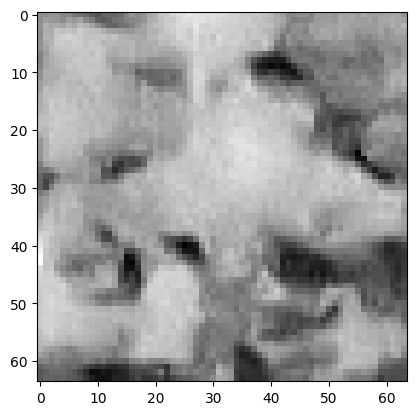

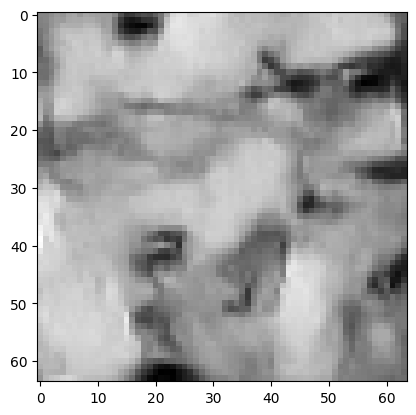

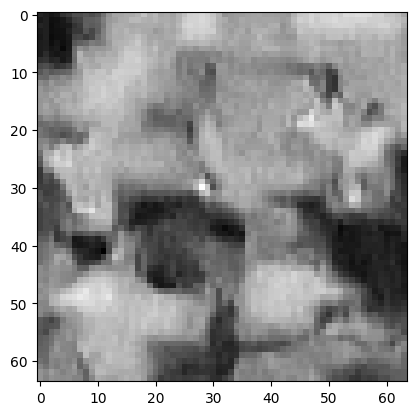

Epoch 62 : 


100%|██████████| 400/400 [00:18<00:00, 21.80it/s]


loss 0.04734612412720293
Epoch 63 : 


100%|██████████| 400/400 [00:18<00:00, 21.96it/s]


loss 0.05548213021703542
Epoch 64 : 


100%|██████████| 400/400 [00:18<00:00, 21.95it/s]


loss 0.09817758203268305
Epoch 65 : 


100%|██████████| 400/400 [00:17<00:00, 22.45it/s]


loss 0.0847803441513549
Epoch 66 : 


100%|██████████| 400/400 [00:18<00:00, 22.05it/s]


loss 0.07545322767773673
Epoch 67 : 


100%|██████████| 400/400 [00:18<00:00, 21.11it/s]


loss 0.05328416131885162
Epoch 68 : 


100%|██████████| 400/400 [00:18<00:00, 21.83it/s]


loss 0.0542279153501594
Epoch 69 : 


100%|██████████| 400/400 [00:18<00:00, 21.78it/s]


loss 0.08928274493213925
Epoch 70 : 


100%|██████████| 400/400 [00:18<00:00, 22.18it/s]


loss 0.08721934570400633
Epoch 71 : 


100%|██████████| 400/400 [00:17<00:00, 22.30it/s]


loss 0.11319048760904457
Epoch 72 : 


100%|██████████| 400/400 [00:18<00:00, 22.06it/s]


loss 0.0641372214515211
Epoch 73 : 


100%|██████████| 400/400 [00:18<00:00, 21.88it/s]


loss 0.055477824763688795
Epoch 74 : 


100%|██████████| 400/400 [00:18<00:00, 21.15it/s]


loss 0.05508582360545015
Epoch 75 : 


100%|██████████| 400/400 [00:18<00:00, 21.34it/s]


loss 0.06861339803196002
Epoch 76 : 


100%|██████████| 400/400 [00:18<00:00, 22.18it/s]


loss 0.08615981140164276
Epoch 77 : 


100%|██████████| 400/400 [00:18<00:00, 21.58it/s]


loss 0.04280408621510161
Epoch 78 : 


100%|██████████| 400/400 [00:18<00:00, 22.08it/s]


loss 0.15010748739931726
Epoch 79 : 


100%|██████████| 400/400 [00:18<00:00, 21.70it/s]


loss 0.07063722571266412
Epoch 80 : 


100%|██████████| 400/400 [00:18<00:00, 21.80it/s]


loss 0.03697271942947513
Epoch 81 : 


100%|██████████| 400/400 [00:17<00:00, 22.36it/s]


loss 0.10340120037920283
torch.Size([3, 1, 64, 64])


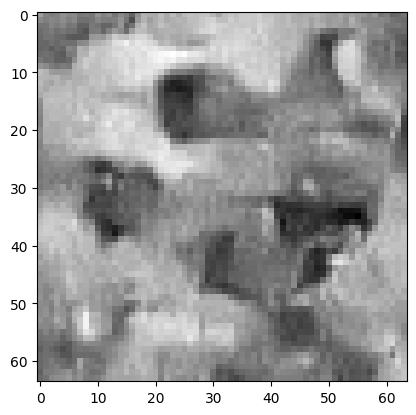

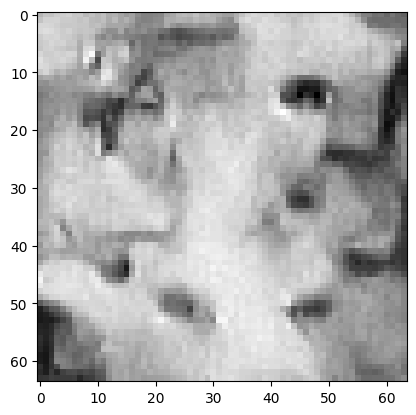

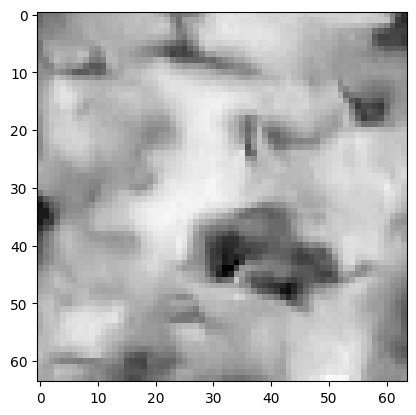

Epoch 82 : 


100%|██████████| 400/400 [00:18<00:00, 21.91it/s]


loss 0.07162094286305204
Epoch 83 : 


100%|██████████| 400/400 [00:18<00:00, 21.65it/s]


loss 0.08779786808452288
Epoch 84 : 


100%|██████████| 400/400 [00:17<00:00, 22.55it/s]


loss 0.09783769722755797
Epoch 85 : 


100%|██████████| 400/400 [00:17<00:00, 22.36it/s]


loss 0.09570683844271782
Epoch 86 : 


100%|██████████| 400/400 [00:17<00:00, 22.45it/s]


loss 0.054071676032388306
Epoch 87 : 


100%|██████████| 400/400 [00:18<00:00, 22.02it/s]


loss 0.05574130845770003
Epoch 88 : 


100%|██████████| 400/400 [00:18<00:00, 22.11it/s]


loss 0.06753690091234052
Epoch 89 : 


100%|██████████| 400/400 [00:18<00:00, 21.92it/s]


loss 0.051244655968247725
Epoch 90 : 


100%|██████████| 400/400 [00:18<00:00, 21.78it/s]


loss 0.059765623831940826
Epoch 91 : 


100%|██████████| 400/400 [00:18<00:00, 21.74it/s]


loss 0.08207498937814738
Epoch 92 : 


100%|██████████| 400/400 [00:18<00:00, 22.11it/s]


loss 0.054523780134942225
Epoch 93 : 


100%|██████████| 400/400 [00:18<00:00, 21.22it/s]


loss 0.0703812348239196
Epoch 94 : 


100%|██████████| 400/400 [00:17<00:00, 22.38it/s]


loss 0.1472394306683099
Epoch 95 : 


100%|██████████| 400/400 [00:18<00:00, 21.98it/s]


loss 0.06558840418994606
Epoch 96 : 


100%|██████████| 400/400 [00:18<00:00, 21.84it/s]


loss 0.05878518353344897
Epoch 97 : 


100%|██████████| 400/400 [00:17<00:00, 22.50it/s]


loss 0.08370497654955131
Epoch 98 : 


100%|██████████| 400/400 [00:17<00:00, 23.00it/s]


loss 0.07423863927369614
Epoch 99 : 


100%|██████████| 400/400 [00:18<00:00, 22.01it/s]


loss 0.08953875018318674


In [49]:
train_ddpm(100, 0.001, 1, 0)

Epoch 0 : 


100%|██████████| 400/400 [00:18<00:00, 21.92it/s]


loss 0.08802762557249644
Epoch 1 : 


100%|██████████| 400/400 [00:18<00:00, 21.58it/s]


loss 0.06608352806185534
torch.Size([3, 1, 64, 64])


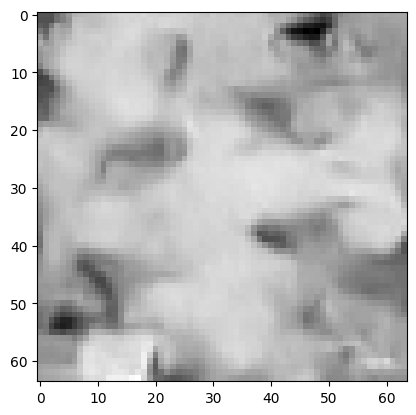

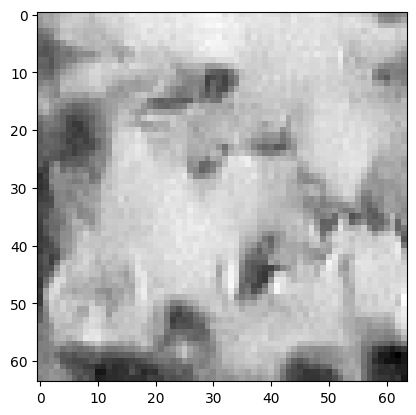

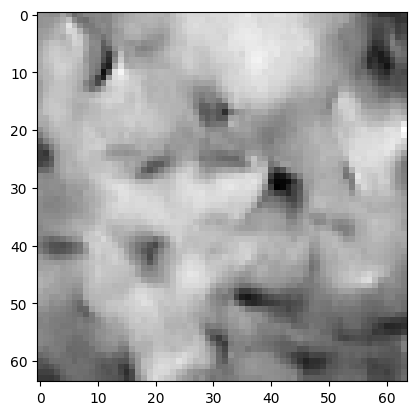

Epoch 2 : 


100%|██████████| 400/400 [00:18<00:00, 21.80it/s]


loss 0.08838549157197705
Epoch 3 : 


100%|██████████| 400/400 [00:18<00:00, 21.32it/s]


loss 0.04578008817287302
Epoch 4 : 


100%|██████████| 400/400 [00:17<00:00, 22.24it/s]


loss 0.059292679293706206
Epoch 5 : 


100%|██████████| 400/400 [00:18<00:00, 21.81it/s]


loss 0.07966648204321777
Epoch 6 : 


100%|██████████| 400/400 [00:18<00:00, 21.93it/s]


loss 0.12665118387676655
Epoch 7 : 


100%|██████████| 400/400 [00:18<00:00, 21.83it/s]


loss 0.06839928693439604
Epoch 8 : 


100%|██████████| 400/400 [00:18<00:00, 21.88it/s]


loss 0.07764387535727743
Epoch 9 : 


100%|██████████| 400/400 [00:18<00:00, 21.75it/s]


loss 0.07244801532468673
Epoch 10 : 


100%|██████████| 400/400 [00:18<00:00, 21.81it/s]


loss 0.05094366592829892
Epoch 11 : 


100%|██████████| 400/400 [00:18<00:00, 21.56it/s]


loss 0.09771282397605761
Epoch 12 : 


100%|██████████| 400/400 [00:18<00:00, 21.75it/s]


loss 0.0815281946248495
Epoch 13 : 


100%|██████████| 400/400 [00:17<00:00, 22.57it/s]


loss 0.03849882785173314
Epoch 14 : 


100%|██████████| 400/400 [00:18<00:00, 21.94it/s]


loss 0.04367771460037304
Epoch 15 : 


100%|██████████| 400/400 [00:17<00:00, 22.25it/s]


loss 0.11093758409854117
Epoch 16 : 


100%|██████████| 400/400 [00:18<00:00, 21.66it/s]


loss 0.08822784754157993
Epoch 17 : 


100%|██████████| 400/400 [00:17<00:00, 22.25it/s]


loss 0.06633079895030485
Epoch 18 : 


100%|██████████| 400/400 [00:17<00:00, 22.52it/s]


loss 0.055447469671641214
Epoch 19 : 


100%|██████████| 400/400 [00:17<00:00, 22.25it/s]


loss 0.1352088671092243
Epoch 20 : 


100%|██████████| 400/400 [00:19<00:00, 20.75it/s]


loss 0.0975408893776047
Epoch 21 : 


100%|██████████| 400/400 [00:19<00:00, 20.21it/s]


loss 0.032355719629246625
torch.Size([3, 1, 64, 64])


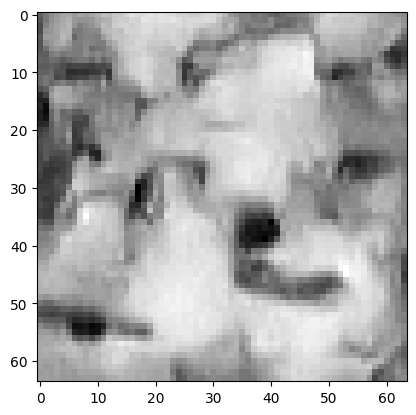

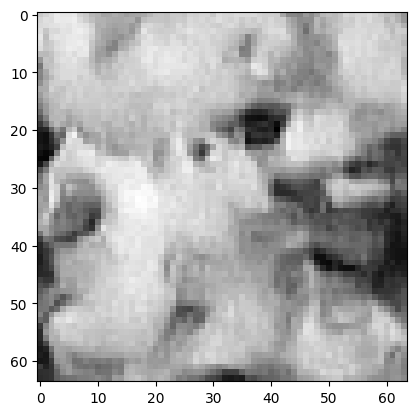

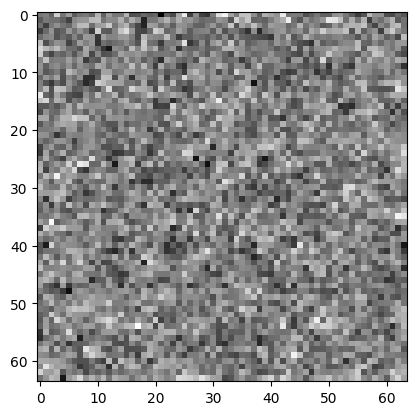

Epoch 22 : 


100%|██████████| 400/400 [00:18<00:00, 21.11it/s]


loss 0.1892430747249828
Epoch 23 : 


100%|██████████| 400/400 [00:19<00:00, 20.81it/s]


loss 0.12821264649402464
Epoch 24 : 


100%|██████████| 400/400 [00:18<00:00, 21.56it/s]


loss 0.06574364176196676
Epoch 25 : 


100%|██████████| 400/400 [00:18<00:00, 21.56it/s]


loss 0.05514954406576456
Epoch 26 : 


100%|██████████| 400/400 [00:18<00:00, 21.60it/s]


loss 0.022030403588120723
Epoch 27 : 


100%|██████████| 400/400 [00:19<00:00, 20.99it/s]


loss 0.07399707121130017
Epoch 28 : 


100%|██████████| 400/400 [00:18<00:00, 21.42it/s]


loss 0.06098639780173702
Epoch 29 : 


100%|██████████| 400/400 [00:18<00:00, 21.36it/s]


loss 0.050893217519239684
Epoch 30 : 


100%|██████████| 400/400 [00:18<00:00, 21.50it/s]


loss 0.08271640661356201
Epoch 31 : 


100%|██████████| 400/400 [00:18<00:00, 21.48it/s]


loss 0.0633045367809222
Epoch 32 : 


100%|██████████| 400/400 [00:18<00:00, 21.97it/s]


loss 0.06454874916880708
Epoch 33 : 


100%|██████████| 400/400 [00:18<00:00, 22.06it/s]


loss 0.06596747059295503
Epoch 34 : 


100%|██████████| 400/400 [00:18<00:00, 21.38it/s]


loss 0.06515901121231527
Epoch 35 : 


100%|██████████| 400/400 [00:19<00:00, 20.77it/s]


loss 0.06372289936447804
Epoch 36 : 


100%|██████████| 400/400 [00:18<00:00, 21.68it/s]


loss 0.05736577162528039
Epoch 37 : 


100%|██████████| 400/400 [00:18<00:00, 21.18it/s]


loss 0.05336792485901347
Epoch 38 : 


100%|██████████| 400/400 [00:19<00:00, 20.96it/s]


loss 0.053793567118258855
Epoch 39 : 


100%|██████████| 400/400 [00:18<00:00, 21.46it/s]


loss 0.036532807341224306
Epoch 40 : 


100%|██████████| 400/400 [00:18<00:00, 21.14it/s]


loss 0.12389356467808195
Epoch 41 : 


100%|██████████| 400/400 [00:18<00:00, 21.14it/s]


loss 0.08304346230159675
torch.Size([3, 1, 64, 64])


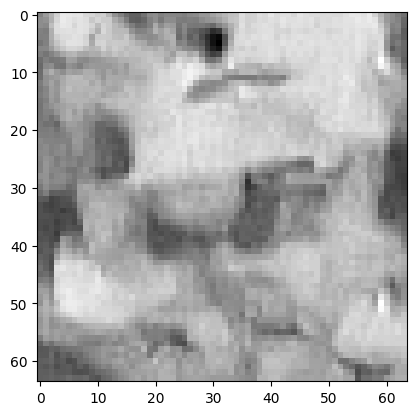

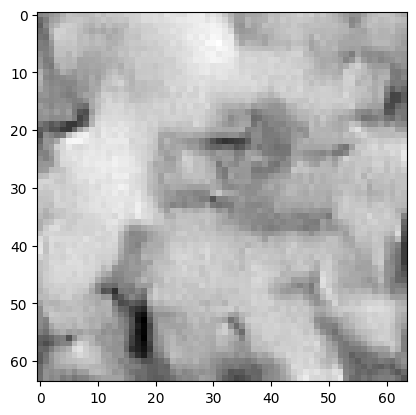

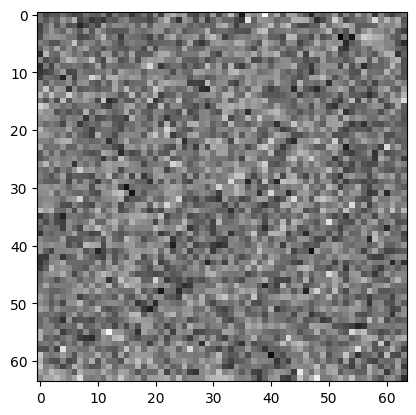

Epoch 42 : 


100%|██████████| 400/400 [00:19<00:00, 20.64it/s]


loss 0.1678897956189745
Epoch 43 : 


100%|██████████| 400/400 [00:18<00:00, 21.32it/s]


loss 0.11826939089623766
Epoch 44 : 


100%|██████████| 400/400 [00:18<00:00, 21.71it/s]


loss 0.09801469366232045
Epoch 45 : 


100%|██████████| 400/400 [00:19<00:00, 20.61it/s]


loss 0.032728402795624036
Epoch 46 : 


100%|██████████| 400/400 [00:18<00:00, 21.79it/s]


loss 0.03780197267861681
Epoch 47 : 


100%|██████████| 400/400 [00:19<00:00, 20.45it/s]


loss 0.07054964950454107
Epoch 48 : 


100%|██████████| 400/400 [00:18<00:00, 21.68it/s]


loss 0.06663736684551093
Epoch 49 : 


100%|██████████| 400/400 [00:18<00:00, 21.98it/s]


loss 0.06663607653446577
Epoch 50 : 


100%|██████████| 400/400 [00:18<00:00, 21.51it/s]


loss 0.034484919132211106
Epoch 51 : 


100%|██████████| 400/400 [00:18<00:00, 21.20it/s]


loss 0.051750830333294064
Epoch 52 : 


100%|██████████| 400/400 [00:18<00:00, 21.16it/s]


loss 0.0668868376460551
Epoch 53 : 


100%|██████████| 400/400 [00:18<00:00, 21.41it/s]


loss 0.09722781290374574
Epoch 54 : 


100%|██████████| 400/400 [00:18<00:00, 22.13it/s]


loss 0.040423303531329356
Epoch 55 : 


100%|██████████| 400/400 [00:19<00:00, 20.52it/s]


loss 0.15025153680939957
Epoch 56 : 


100%|██████████| 400/400 [00:18<00:00, 21.22it/s]


loss 0.0686587141416353
Epoch 57 : 


100%|██████████| 400/400 [00:18<00:00, 21.39it/s]


loss 0.07606085915924428
Epoch 58 : 


100%|██████████| 400/400 [00:19<00:00, 20.71it/s]


loss 0.104607341565867
Epoch 59 : 


100%|██████████| 400/400 [00:19<00:00, 20.66it/s]


loss 0.028064180473128766
Epoch 60 : 


100%|██████████| 400/400 [00:19<00:00, 20.05it/s]


loss 0.052221837288223244
Epoch 61 : 


100%|██████████| 400/400 [00:19<00:00, 20.43it/s]


loss 0.08053716398270427
torch.Size([3, 1, 64, 64])


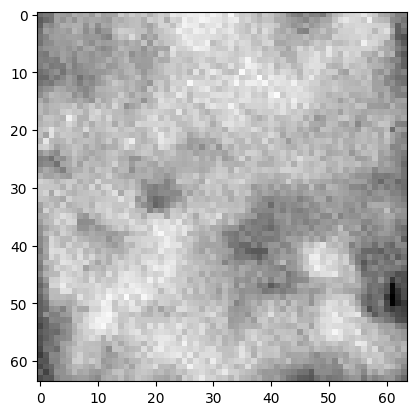

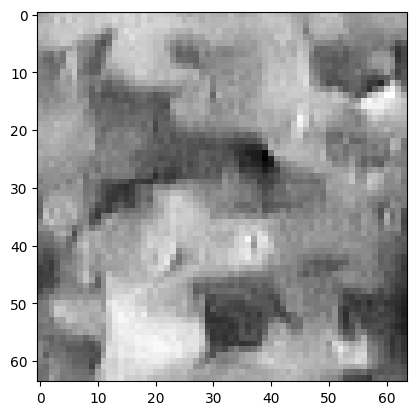

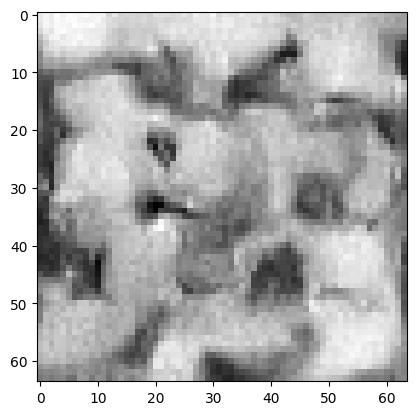

Epoch 62 : 


100%|██████████| 400/400 [00:18<00:00, 21.38it/s]


loss 0.1163522108075298
Epoch 63 : 


100%|██████████| 400/400 [00:18<00:00, 21.20it/s]


loss 0.07311075538076843
Epoch 64 : 


100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


loss 0.07048323827195466
Epoch 65 : 


100%|██████████| 400/400 [00:19<00:00, 20.99it/s]


loss 0.07029874804007236
Epoch 66 : 


100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


loss 0.08488943110124844
Epoch 67 : 


100%|██████████| 400/400 [00:18<00:00, 21.50it/s]


loss 0.07073723244483543
Epoch 68 : 


100%|██████████| 400/400 [00:18<00:00, 21.25it/s]


loss 0.1270195268425888
Epoch 69 : 


100%|██████████| 400/400 [00:19<00:00, 20.89it/s]


loss 0.09819600838415826
Epoch 70 : 


100%|██████████| 400/400 [00:19<00:00, 20.26it/s]


loss 0.166155310768515
Epoch 71 : 


100%|██████████| 400/400 [00:19<00:00, 20.14it/s]


loss 0.056891703386392434
Epoch 72 : 


100%|██████████| 400/400 [00:18<00:00, 21.24it/s]


loss 0.08264397549804646
Epoch 73 : 


100%|██████████| 400/400 [00:18<00:00, 21.25it/s]


loss 0.06800545586907987
Epoch 74 : 


100%|██████████| 400/400 [00:19<00:00, 20.47it/s]


loss 0.16495184209941877
Epoch 75 : 


100%|██████████| 400/400 [00:19<00:00, 20.99it/s]


loss 0.0863454157569587
Epoch 76 : 


100%|██████████| 400/400 [00:18<00:00, 21.10it/s]


loss 0.06107613540268593
Epoch 77 : 


100%|██████████| 400/400 [00:18<00:00, 21.20it/s]


loss 0.06604830768644267
Epoch 78 : 


100%|██████████| 400/400 [00:19<00:00, 20.58it/s]


loss 0.04948723337088069
Epoch 79 : 


100%|██████████| 400/400 [00:19<00:00, 20.72it/s]


loss 0.04327592263534519
Epoch 80 : 


100%|██████████| 400/400 [00:18<00:00, 21.50it/s]


loss 0.048531052029960275
Epoch 81 : 


100%|██████████| 400/400 [00:19<00:00, 20.42it/s]


loss 0.11688884578131802
torch.Size([3, 1, 64, 64])


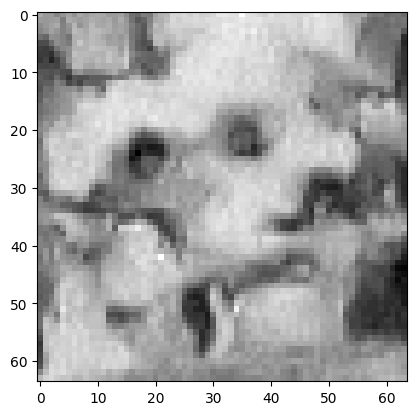

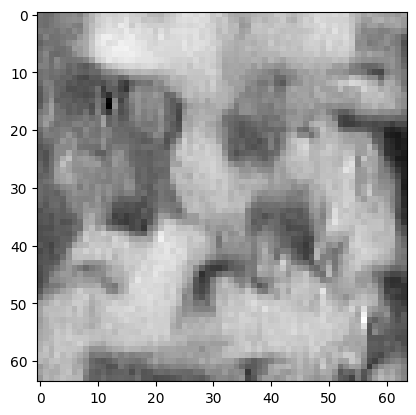

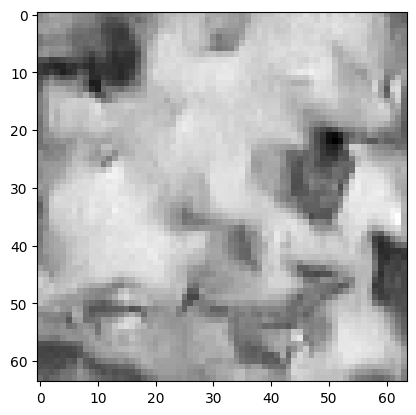

Epoch 82 : 


100%|██████████| 400/400 [00:19<00:00, 20.35it/s]


loss 0.1112557105090147
Epoch 83 : 


100%|██████████| 400/400 [00:19<00:00, 20.56it/s]


loss 0.05326216840269128
Epoch 84 : 


100%|██████████| 400/400 [00:19<00:00, 20.15it/s]


loss 0.06273592865128748
Epoch 85 : 


100%|██████████| 400/400 [00:18<00:00, 21.50it/s]


loss 0.16610444128050902
Epoch 86 : 


100%|██████████| 400/400 [00:19<00:00, 20.60it/s]


loss 0.1345245105065683
Epoch 87 : 


100%|██████████| 400/400 [00:19<00:00, 20.45it/s]


loss 0.06537108677975109
Epoch 88 : 


100%|██████████| 400/400 [00:19<00:00, 20.43it/s]


loss 0.06871543467913246
Epoch 89 : 


100%|██████████| 400/400 [00:20<00:00, 19.97it/s]


loss 0.10903303025972086
Epoch 90 : 


100%|██████████| 400/400 [00:19<00:00, 20.09it/s]


loss 0.04102800619206715
Epoch 91 : 


100%|██████████| 400/400 [00:19<00:00, 20.01it/s]


loss 0.06019470296908702
Epoch 92 : 


100%|██████████| 400/400 [00:19<00:00, 20.00it/s]


loss 0.08196142476711339
Epoch 93 : 


100%|██████████| 400/400 [00:19<00:00, 20.61it/s]


loss 0.10665247996027316
Epoch 94 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.0381857774875597
Epoch 95 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.05609552705414583
Epoch 96 : 


100%|██████████| 400/400 [00:19<00:00, 20.14it/s]


loss 0.12796903437313117
Epoch 97 : 


100%|██████████| 400/400 [00:19<00:00, 20.50it/s]


loss 0.042405601239327406
Epoch 98 : 


100%|██████████| 400/400 [00:19<00:00, 20.99it/s]


loss 0.09901843709873547
Epoch 99 : 


100%|██████████| 400/400 [00:19<00:00, 20.23it/s]


loss 0.1662884319137597


In [50]:
train_ddpm(100, 0.001, 1, 0)

Epoch 0 : 


100%|██████████| 400/400 [00:18<00:00, 21.50it/s]


loss 0.07214724892645615
Epoch 1 : 


100%|██████████| 400/400 [00:19<00:00, 20.15it/s]


loss 0.11973758969509718
torch.Size([3, 1, 64, 64])


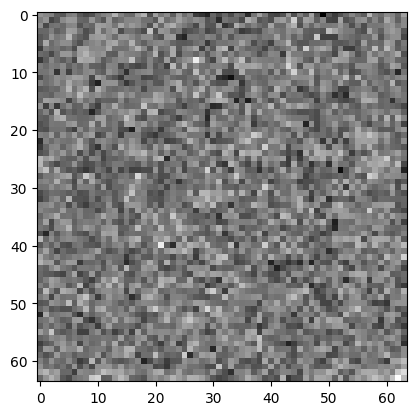

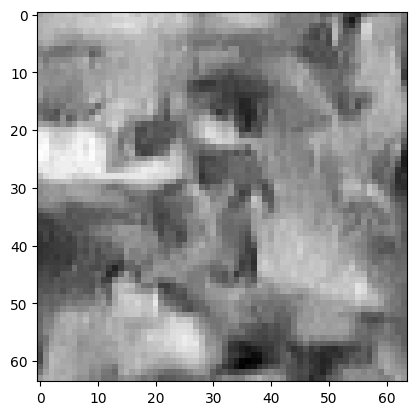

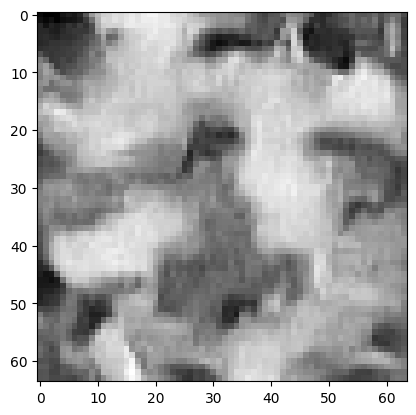

Epoch 2 : 


100%|██████████| 400/400 [00:19<00:00, 20.32it/s]


loss 0.0843435027613111
Epoch 3 : 


100%|██████████| 400/400 [00:19<00:00, 20.64it/s]


loss 0.09044735436290091
Epoch 4 : 


100%|██████████| 400/400 [00:19<00:00, 20.02it/s]


loss 0.06309526239972059
Epoch 5 : 


100%|██████████| 400/400 [00:19<00:00, 20.08it/s]


loss 0.08445626622393926
Epoch 6 : 


100%|██████████| 400/400 [00:19<00:00, 20.33it/s]


loss 0.09063207880285995
Epoch 7 : 


100%|██████████| 400/400 [00:20<00:00, 19.82it/s]


loss 0.09058061127948348
Epoch 8 : 


100%|██████████| 400/400 [00:19<00:00, 20.32it/s]


loss 0.07800603793021714
Epoch 9 : 


100%|██████████| 400/400 [00:19<00:00, 20.48it/s]


loss 0.05739439032151509
Epoch 10 : 


100%|██████████| 400/400 [00:19<00:00, 20.97it/s]


loss 0.06300829969788464
Epoch 11 : 


100%|██████████| 400/400 [00:20<00:00, 19.36it/s]


loss 0.08273224438794241
Epoch 12 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.040542136115569304
Epoch 13 : 


100%|██████████| 400/400 [00:19<00:00, 21.05it/s]


loss 0.0924419305725774
Epoch 14 : 


100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


loss 0.040215864871787035
Epoch 15 : 


100%|██████████| 400/400 [00:19<00:00, 20.32it/s]


loss 0.054687363697991306
Epoch 16 : 


100%|██████████| 400/400 [00:19<00:00, 20.80it/s]


loss 0.05002801550458207
Epoch 17 : 


100%|██████████| 400/400 [00:19<00:00, 20.53it/s]


loss 0.06766744131705126
Epoch 18 : 


100%|██████████| 400/400 [00:19<00:00, 20.05it/s]


loss 0.11160285121896042
Epoch 19 : 


100%|██████████| 400/400 [00:18<00:00, 21.06it/s]


loss 0.05051554495846603
Epoch 20 : 


100%|██████████| 400/400 [00:19<00:00, 20.24it/s]


loss 0.05917566649931497
Epoch 21 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.08897576338225759
torch.Size([3, 1, 64, 64])


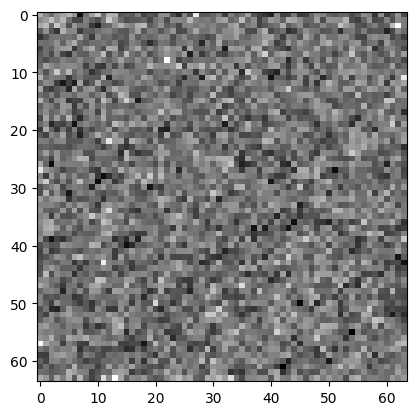

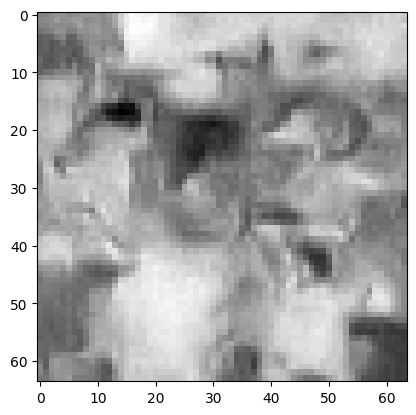

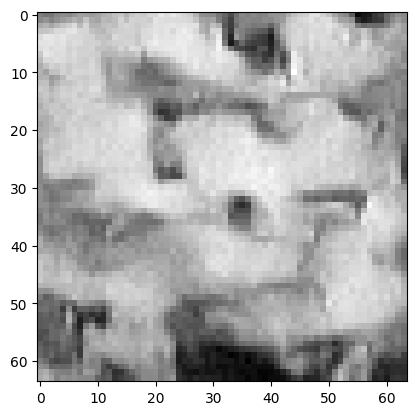

Epoch 22 : 


100%|██████████| 400/400 [00:19<00:00, 20.04it/s]


loss 0.06333102674056713
Epoch 23 : 


100%|██████████| 400/400 [00:19<00:00, 20.53it/s]


loss 0.039868444516876336
Epoch 24 : 


100%|██████████| 400/400 [00:19<00:00, 20.63it/s]


loss 0.026389180915459328
Epoch 25 : 


100%|██████████| 400/400 [00:18<00:00, 21.20it/s]


loss 0.087099543801733
Epoch 26 : 


100%|██████████| 400/400 [00:18<00:00, 21.44it/s]


loss 0.08957200477539749
Epoch 27 : 


100%|██████████| 400/400 [00:18<00:00, 21.69it/s]


loss 0.060753196644488
Epoch 28 : 


100%|██████████| 400/400 [00:18<00:00, 21.38it/s]


loss 0.11821898104928641
Epoch 29 : 


100%|██████████| 400/400 [00:18<00:00, 21.62it/s]


loss 0.08705819930465011
Epoch 30 : 


100%|██████████| 400/400 [00:19<00:00, 20.40it/s]


loss 0.10293569919986043
Epoch 31 : 


100%|██████████| 400/400 [00:18<00:00, 21.49it/s]


loss 0.11384366445243722
Epoch 32 : 


100%|██████████| 400/400 [00:19<00:00, 20.41it/s]


loss 0.04950774530836748
Epoch 33 : 


100%|██████████| 400/400 [00:19<00:00, 20.28it/s]


loss 0.060391590967734075
Epoch 34 : 


100%|██████████| 400/400 [00:19<00:00, 20.83it/s]


loss 0.051649567763457686
Epoch 35 : 


100%|██████████| 400/400 [00:19<00:00, 20.85it/s]


loss 0.05262181301961241
Epoch 36 : 


100%|██████████| 400/400 [00:18<00:00, 21.61it/s]


loss 0.06450663633507944
Epoch 37 : 


100%|██████████| 400/400 [00:18<00:00, 21.36it/s]


loss 0.1195302252499367
Epoch 38 : 


100%|██████████| 400/400 [00:19<00:00, 20.54it/s]


loss 0.032084264315599624
Epoch 39 : 


100%|██████████| 400/400 [00:18<00:00, 21.80it/s]


loss 0.10734044219771244
Epoch 40 : 


100%|██████████| 400/400 [00:18<00:00, 21.15it/s]


loss 0.11210558346531259
Epoch 41 : 


100%|██████████| 400/400 [00:18<00:00, 21.11it/s]


loss 0.06304882789758534
torch.Size([3, 1, 64, 64])


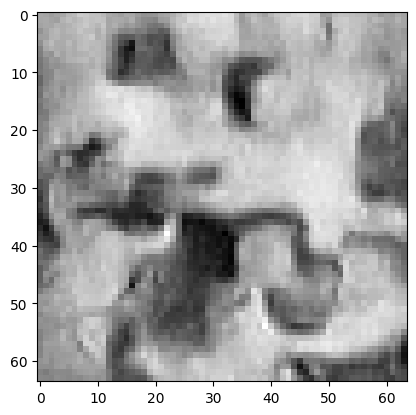

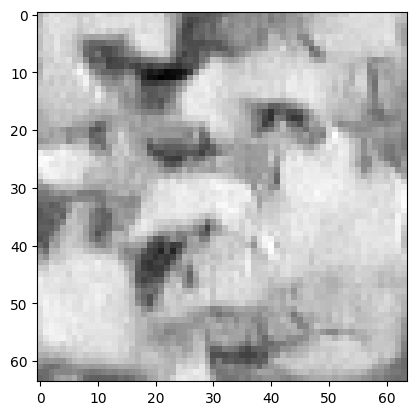

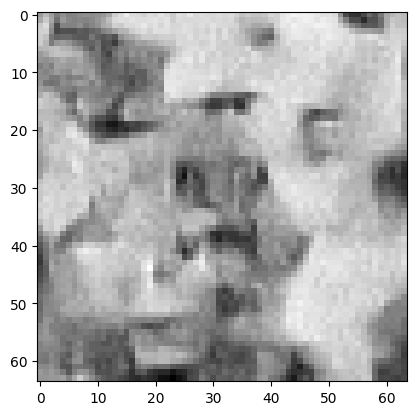

Epoch 42 : 


100%|██████████| 400/400 [00:19<00:00, 20.43it/s]


loss 0.09250897538280456
Epoch 43 : 


100%|██████████| 400/400 [00:18<00:00, 21.57it/s]


loss 0.05813069726013706
Epoch 44 : 


100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


loss 0.021960426075861957
Epoch 45 : 


100%|██████████| 400/400 [00:18<00:00, 21.80it/s]


loss 0.06824233890858884
Epoch 46 : 


100%|██████████| 400/400 [00:19<00:00, 21.04it/s]


loss 0.044465895368482874
Epoch 47 : 


100%|██████████| 400/400 [00:20<00:00, 19.92it/s]


loss 0.11939759049371482
Epoch 48 : 


100%|██████████| 400/400 [00:18<00:00, 21.10it/s]


loss 0.05418458657694623
Epoch 49 : 


100%|██████████| 400/400 [00:19<00:00, 20.30it/s]


loss 0.11774867056600581
Epoch 50 : 


100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


loss 0.04201868070442224
Epoch 51 : 


100%|██████████| 400/400 [00:19<00:00, 20.38it/s]


loss 0.08597496792922935
Epoch 52 : 


100%|██████████| 400/400 [00:18<00:00, 21.56it/s]


loss 0.05313427775057797
Epoch 53 : 


100%|██████████| 400/400 [00:19<00:00, 20.33it/s]


loss 0.06878646258099416
Epoch 54 : 


100%|██████████| 400/400 [00:18<00:00, 21.41it/s]


loss 0.14283883804502717
Epoch 55 : 


100%|██████████| 400/400 [00:19<00:00, 21.03it/s]


loss 0.105539752386566
Epoch 56 : 


100%|██████████| 400/400 [00:18<00:00, 21.61it/s]


loss 0.07026480976220083
Epoch 57 : 


100%|██████████| 400/400 [00:19<00:00, 20.95it/s]


loss 0.062168623302190154
Epoch 58 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.029952176475215513
Epoch 59 : 


100%|██████████| 400/400 [00:19<00:00, 20.40it/s]


loss 0.03952473084579265
Epoch 60 : 


100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


loss 0.03129373381024126
Epoch 61 : 


100%|██████████| 400/400 [00:18<00:00, 21.11it/s]


loss 0.03493611793647068
torch.Size([3, 1, 64, 64])


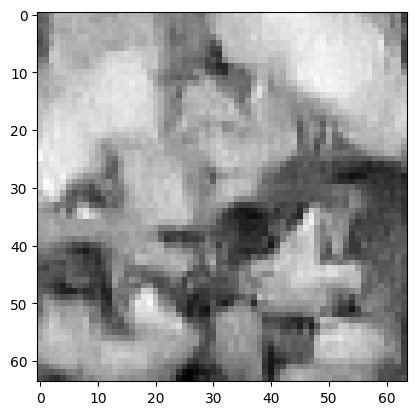

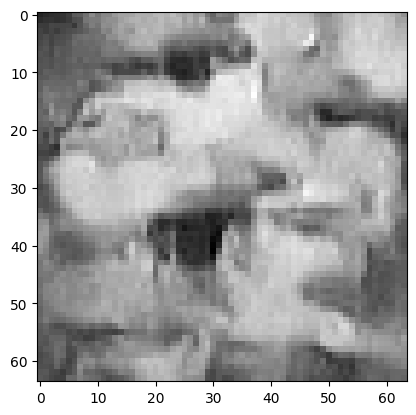

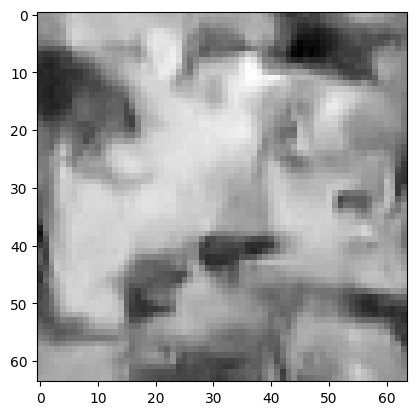

Epoch 62 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.09027620989554477
Epoch 63 : 


100%|██████████| 400/400 [00:18<00:00, 21.23it/s]


loss 0.07588299244123804
Epoch 64 : 


100%|██████████| 400/400 [00:19<00:00, 20.96it/s]


loss 0.06974565613145539
Epoch 65 : 


100%|██████████| 400/400 [00:18<00:00, 21.46it/s]


loss 0.0698548892438466
Epoch 66 : 


100%|██████████| 400/400 [00:19<00:00, 20.85it/s]


loss 0.05471325009643173
Epoch 67 : 


100%|██████████| 400/400 [00:18<00:00, 21.46it/s]


loss 0.06346879434349598
Epoch 68 : 


100%|██████████| 400/400 [00:19<00:00, 20.51it/s]


loss 0.0724480253754793
Epoch 69 : 


100%|██████████| 400/400 [00:18<00:00, 21.27it/s]


loss 0.03595799581135838
Epoch 70 : 


100%|██████████| 400/400 [00:19<00:00, 20.37it/s]


loss 0.03994597367383019
Epoch 71 : 


100%|██████████| 400/400 [00:18<00:00, 21.19it/s]


loss 0.14806888346890507
Epoch 72 : 


100%|██████████| 400/400 [00:19<00:00, 20.98it/s]


loss 0.05093308734109989
Epoch 73 : 


100%|██████████| 400/400 [00:19<00:00, 20.42it/s]


loss 0.05996309773062063
Epoch 74 : 


100%|██████████| 400/400 [00:18<00:00, 21.47it/s]


loss 0.11237541843923946
Epoch 75 : 


100%|██████████| 400/400 [00:19<00:00, 20.73it/s]


loss 0.06439099228906923
Epoch 76 : 


100%|██████████| 400/400 [00:18<00:00, 21.08it/s]


loss 0.04580551466226353
Epoch 77 : 


100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


loss 0.0805415646045155
Epoch 78 : 


100%|██████████| 400/400 [00:19<00:00, 20.87it/s]


loss 0.04920537004925454
Epoch 79 : 


100%|██████████| 400/400 [00:19<00:00, 20.82it/s]


loss 0.10990512077479063
Epoch 80 : 


100%|██████████| 400/400 [00:19<00:00, 20.45it/s]


loss 0.03922959238370835
Epoch 81 : 


100%|██████████| 400/400 [00:18<00:00, 21.28it/s]


loss 0.04012607884875981
torch.Size([3, 1, 64, 64])


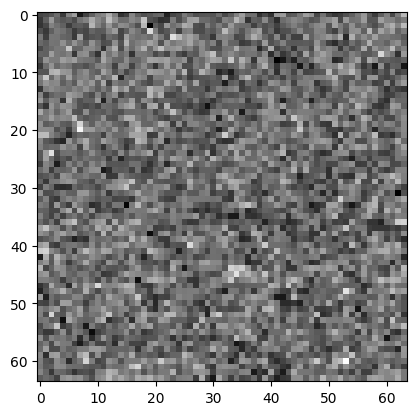

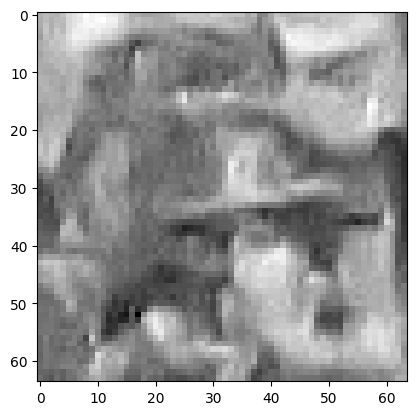

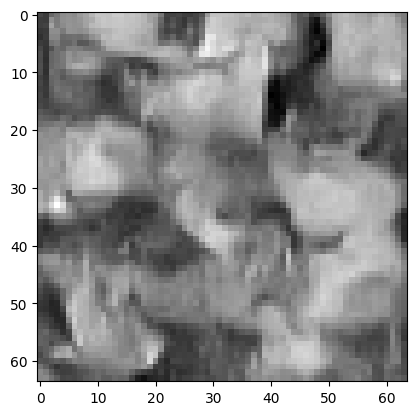

Epoch 82 : 


100%|██████████| 400/400 [00:18<00:00, 21.23it/s]


loss 0.06123278140451459
Epoch 83 : 


100%|██████████| 400/400 [00:19<00:00, 20.68it/s]


loss 0.06527437063863073
Epoch 84 : 


100%|██████████| 400/400 [00:19<00:00, 20.58it/s]


loss 0.045431329601775775
Epoch 85 : 


100%|██████████| 400/400 [00:19<00:00, 20.64it/s]


loss 0.05143128173125363
Epoch 86 : 


100%|██████████| 400/400 [00:20<00:00, 19.97it/s]


loss 0.09321152610753823
Epoch 87 : 


100%|██████████| 400/400 [00:19<00:00, 21.05it/s]


loss 0.03880795322444059
Epoch 88 : 


100%|██████████| 400/400 [00:19<00:00, 20.92it/s]


loss 0.04974229375752349
Epoch 89 : 


100%|██████████| 400/400 [00:19<00:00, 20.33it/s]


loss 0.06554297543576956
Epoch 90 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.0626712272537062
Epoch 91 : 


100%|██████████| 400/400 [00:19<00:00, 20.89it/s]


loss 0.10387790771256662
Epoch 92 : 


100%|██████████| 400/400 [00:19<00:00, 20.24it/s]


loss 0.15987056287017515
Epoch 93 : 


100%|██████████| 400/400 [00:19<00:00, 20.75it/s]


loss 0.05374132588286845
Epoch 94 : 


100%|██████████| 400/400 [00:19<00:00, 20.92it/s]


loss 0.04273039315391517
Epoch 95 : 


100%|██████████| 400/400 [00:20<00:00, 19.87it/s]


loss 0.0784143542355009
Epoch 96 : 


100%|██████████| 400/400 [00:19<00:00, 20.13it/s]


loss 0.03678017925300027
Epoch 97 : 


100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


loss 0.036419442056344856
Epoch 98 : 


100%|██████████| 400/400 [00:18<00:00, 21.18it/s]


loss 0.13233606368718998
Epoch 99 : 


100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


loss 0.08911928458494271
Epoch 100 : 


100%|██████████| 400/400 [00:20<00:00, 19.55it/s]


loss 0.12836744237285586
Epoch 101 : 


100%|██████████| 400/400 [00:18<00:00, 21.40it/s]


loss 0.06522074834441946
torch.Size([3, 1, 64, 64])


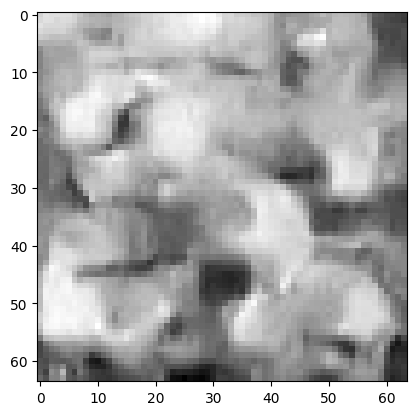

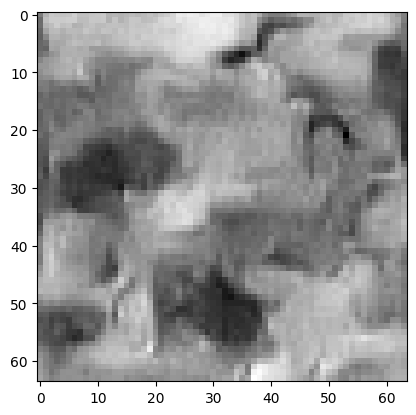

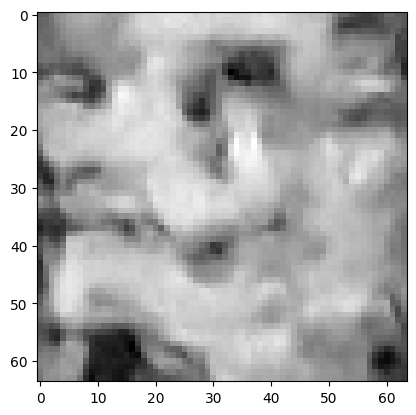

Epoch 102 : 


100%|██████████| 400/400 [00:19<00:00, 20.20it/s]


loss 0.049740199402157036
Epoch 103 : 


100%|██████████| 400/400 [00:19<00:00, 20.90it/s]


loss 0.043105815426155464
Epoch 104 : 


100%|██████████| 400/400 [00:19<00:00, 20.67it/s]


loss 0.048992429673915636
Epoch 105 : 


100%|██████████| 400/400 [00:19<00:00, 20.41it/s]


loss 0.10270125154094951
Epoch 106 : 


100%|██████████| 400/400 [00:19<00:00, 20.86it/s]


loss 0.08418409807542691
Epoch 107 : 


100%|██████████| 400/400 [00:19<00:00, 20.14it/s]


loss 0.12402660057243489
Epoch 108 : 


100%|██████████| 400/400 [00:19<00:00, 20.98it/s]


loss 0.07332111840734709
Epoch 109 : 


100%|██████████| 400/400 [00:19<00:00, 20.38it/s]


loss 0.07946987672404451
Epoch 110 : 


100%|██████████| 400/400 [00:18<00:00, 21.25it/s]


loss 0.05954933535986062
Epoch 111 : 


100%|██████████| 400/400 [00:19<00:00, 20.46it/s]


loss 0.06950328113018595
Epoch 112 : 


100%|██████████| 400/400 [00:19<00:00, 21.03it/s]


loss 0.06523366502615481
Epoch 113 : 


100%|██████████| 400/400 [00:19<00:00, 20.24it/s]


loss 0.0512905358421616
Epoch 114 : 


100%|██████████| 400/400 [00:18<00:00, 21.08it/s]


loss 0.057784614623234566
Epoch 115 : 


100%|██████████| 400/400 [00:18<00:00, 21.41it/s]


loss 0.026569379618530356
Epoch 116 : 


100%|██████████| 400/400 [00:18<00:00, 21.30it/s]


loss 0.06021537425648173
Epoch 117 : 


100%|██████████| 400/400 [00:19<00:00, 20.83it/s]


loss 0.0742034318055752
Epoch 118 : 


100%|██████████| 400/400 [00:19<00:00, 20.66it/s]


loss 0.08141821643475747
Epoch 119 : 


100%|██████████| 400/400 [00:19<00:00, 20.63it/s]


loss 0.10347360264900561
Epoch 120 : 


100%|██████████| 400/400 [00:20<00:00, 19.77it/s]


loss 0.08346994640866501
Epoch 121 : 


100%|██████████| 400/400 [00:19<00:00, 20.26it/s]


loss 0.08825795822834846
torch.Size([3, 1, 64, 64])


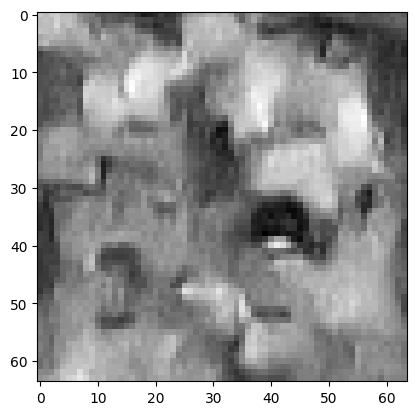

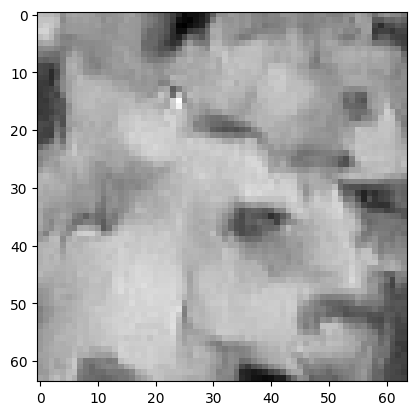

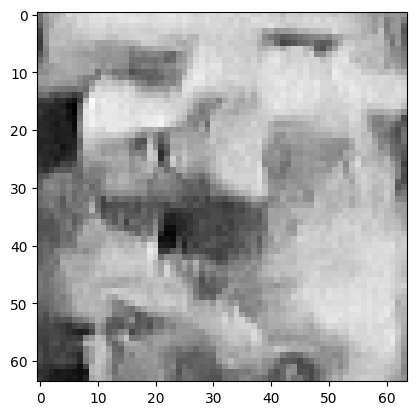

Epoch 122 : 


100%|██████████| 400/400 [00:19<00:00, 20.56it/s]


loss 0.1814349246173137
Epoch 123 : 


100%|██████████| 400/400 [00:19<00:00, 20.77it/s]


loss 0.07987424591164553
Epoch 124 : 


100%|██████████| 400/400 [00:18<00:00, 21.25it/s]


loss 0.05805758926958972
Epoch 125 : 


100%|██████████| 400/400 [00:18<00:00, 21.12it/s]


loss 0.07352407244104564
Epoch 126 : 


100%|██████████| 400/400 [00:18<00:00, 21.50it/s]


loss 0.05783581225151073
Epoch 127 : 


100%|██████████| 400/400 [00:19<00:00, 20.72it/s]


loss 0.05123141223029441
Epoch 128 : 


100%|██████████| 400/400 [00:18<00:00, 21.37it/s]


loss 0.04646691097269424
Epoch 129 : 


100%|██████████| 400/400 [00:18<00:00, 21.08it/s]


loss 0.07846308803071908
Epoch 130 : 


100%|██████████| 400/400 [00:18<00:00, 21.46it/s]


loss 0.10316799304690423
Epoch 131 : 


100%|██████████| 400/400 [00:19<00:00, 21.05it/s]


loss 0.085492316623939
Epoch 132 : 


100%|██████████| 400/400 [00:18<00:00, 21.18it/s]


loss 0.04825099204137845
Epoch 133 : 


100%|██████████| 400/400 [00:19<00:00, 20.91it/s]


loss 0.09295238861724739
Epoch 134 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.0598333375479447
Epoch 135 : 


100%|██████████| 400/400 [00:18<00:00, 21.44it/s]


loss 0.08331521462546139
Epoch 136 : 


100%|██████████| 400/400 [00:19<00:00, 20.89it/s]


loss 0.06518849719228385
Epoch 137 : 


100%|██████████| 400/400 [00:19<00:00, 20.97it/s]


loss 0.11250786054113204
Epoch 138 : 


100%|██████████| 400/400 [00:19<00:00, 20.59it/s]


loss 0.09254043223567479
Epoch 139 : 


100%|██████████| 400/400 [00:18<00:00, 21.17it/s]


loss 0.06292766571886613
Epoch 140 : 


100%|██████████| 400/400 [00:19<00:00, 20.48it/s]


loss 0.051040145595593514
Epoch 141 : 


100%|██████████| 400/400 [00:19<00:00, 20.98it/s]


loss 0.10929139211883651
torch.Size([3, 1, 64, 64])


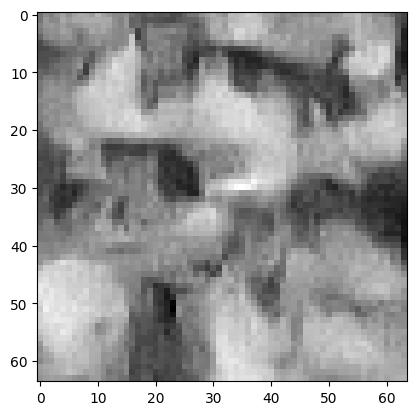

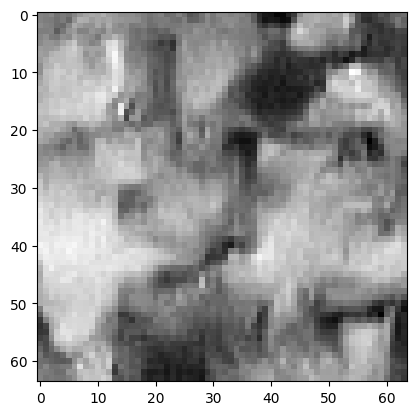

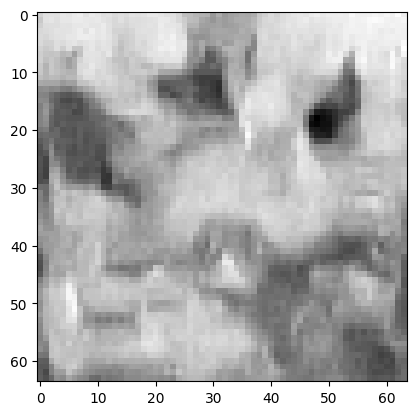

Epoch 142 : 


100%|██████████| 400/400 [00:19<00:00, 20.74it/s]


loss 0.07464669162688267
Epoch 143 : 


100%|██████████| 400/400 [00:19<00:00, 20.90it/s]


loss 0.031416009267283135
Epoch 144 : 


100%|██████████| 400/400 [00:19<00:00, 20.42it/s]


loss 0.03678491443655269
Epoch 145 : 


100%|██████████| 400/400 [00:18<00:00, 21.27it/s]


loss 0.12754585445432778
Epoch 146 : 


100%|██████████| 400/400 [00:19<00:00, 20.83it/s]


loss 0.02772210249410725
Epoch 147 : 


100%|██████████| 400/400 [00:18<00:00, 21.51it/s]


loss 0.04866224569343379
Epoch 148 : 


100%|██████████| 400/400 [00:19<00:00, 20.35it/s]


loss 0.07412115640554064
Epoch 149 : 


100%|██████████| 400/400 [00:19<00:00, 20.78it/s]


loss 0.08652541834998394
Epoch 150 : 


100%|██████████| 400/400 [00:18<00:00, 21.06it/s]


loss 0.09006723351600918
Epoch 151 : 


100%|██████████| 400/400 [00:17<00:00, 22.72it/s]


loss 0.17496423860275745
Epoch 152 : 


100%|██████████| 400/400 [00:18<00:00, 21.35it/s]


loss 0.07543111960057015
Epoch 153 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.05063200791714009
Epoch 154 : 


100%|██████████| 400/400 [00:19<00:00, 21.01it/s]


loss 0.09918169660057674
Epoch 155 : 


100%|██████████| 400/400 [00:19<00:00, 20.44it/s]


loss 0.13880862044678913
Epoch 156 : 


100%|██████████| 400/400 [00:19<00:00, 20.48it/s]


loss 0.03939524834733183
Epoch 157 : 


100%|██████████| 400/400 [00:19<00:00, 20.31it/s]


loss 0.1259757092409558
Epoch 158 : 


100%|██████████| 400/400 [00:20<00:00, 19.95it/s]


loss 0.06066590786858394
Epoch 159 : 


100%|██████████| 400/400 [00:20<00:00, 19.72it/s]


loss 0.05280362674434152
Epoch 160 : 


100%|██████████| 400/400 [00:19<00:00, 20.18it/s]


loss 0.08106246790474195
Epoch 161 : 


100%|██████████| 400/400 [00:19<00:00, 20.82it/s]


loss 0.06358209378594319
torch.Size([3, 1, 64, 64])


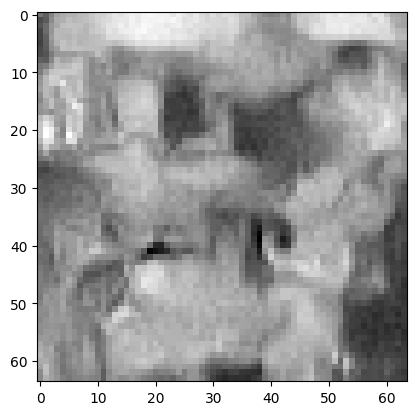

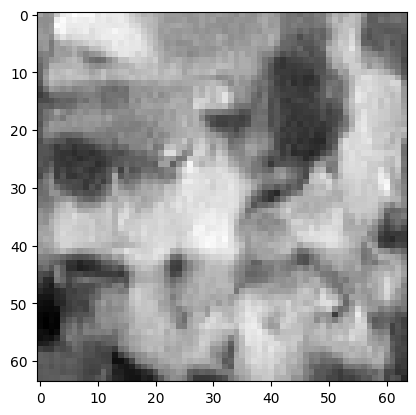

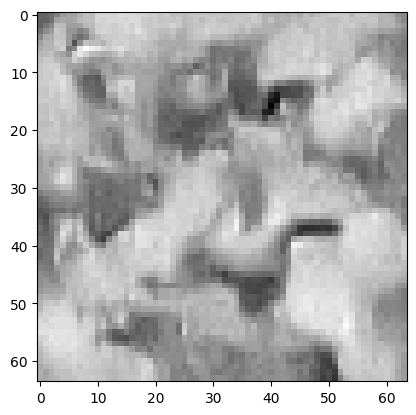

Epoch 162 : 


100%|██████████| 400/400 [00:19<00:00, 20.44it/s]


loss 0.06104419058877349
Epoch 163 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.09082610479807872
Epoch 164 : 


100%|██████████| 400/400 [00:19<00:00, 20.25it/s]


loss 0.0527786768854317
Epoch 165 : 


100%|██████████| 400/400 [00:21<00:00, 18.70it/s]


loss 0.04900361885571305
Epoch 166 : 


100%|██████████| 400/400 [00:19<00:00, 20.45it/s]


loss 0.03994660157542789
Epoch 167 : 


100%|██████████| 400/400 [00:20<00:00, 19.97it/s]


loss 0.1171445803724826
Epoch 168 : 


100%|██████████| 400/400 [00:19<00:00, 20.37it/s]


loss 0.04974980492312153
Epoch 169 : 


100%|██████████| 400/400 [00:20<00:00, 19.92it/s]


loss 0.13637681474090568
Epoch 170 : 


100%|██████████| 400/400 [00:20<00:00, 19.77it/s]


loss 0.06888197935657402
Epoch 171 : 


100%|██████████| 400/400 [00:20<00:00, 19.71it/s]


loss 0.05734329721735199
Epoch 172 : 


100%|██████████| 400/400 [00:19<00:00, 20.16it/s]


loss 0.056878800306315425
Epoch 173 : 


100%|██████████| 400/400 [00:19<00:00, 20.00it/s]


loss 0.11368310010259002
Epoch 174 : 


100%|██████████| 400/400 [00:19<00:00, 20.15it/s]


loss 0.07864565581567946
Epoch 175 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.08450560950346342
Epoch 176 : 


100%|██████████| 400/400 [00:20<00:00, 19.09it/s]


loss 0.055785158752359176
Epoch 177 : 


100%|██████████| 400/400 [00:18<00:00, 21.13it/s]


loss 0.040384937206534376
Epoch 178 : 


100%|██████████| 400/400 [00:19<00:00, 20.41it/s]


loss 0.05073843877952171
Epoch 179 : 


100%|██████████| 400/400 [00:20<00:00, 19.40it/s]


loss 0.07220541115223453
Epoch 180 : 


100%|██████████| 400/400 [00:20<00:00, 19.78it/s]


loss 0.034954106783892894
Epoch 181 : 


100%|██████████| 400/400 [00:19<00:00, 20.72it/s]


loss 0.05965731135796567
torch.Size([3, 1, 64, 64])


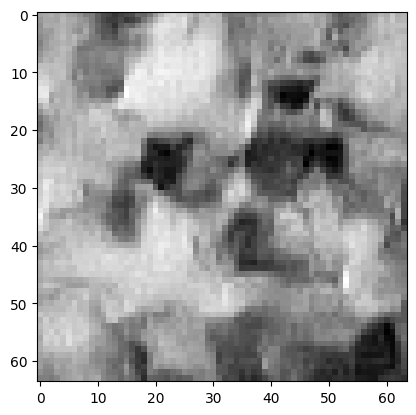

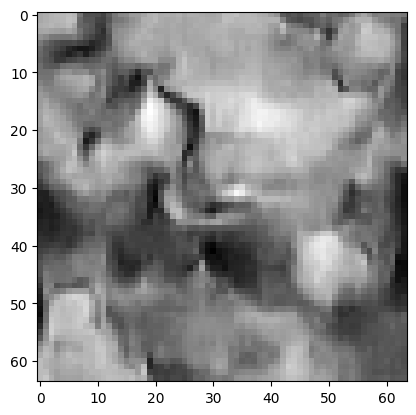

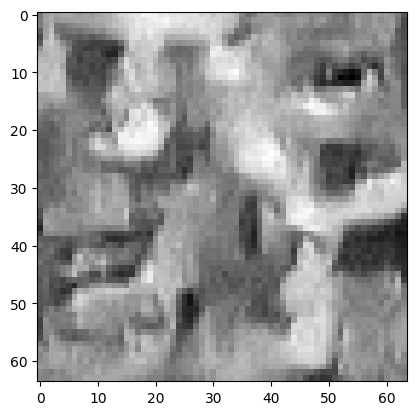

Epoch 182 : 


100%|██████████| 400/400 [00:20<00:00, 19.92it/s]


loss 0.06521003941267414
Epoch 183 : 


100%|██████████| 400/400 [00:20<00:00, 19.49it/s]


loss 0.08190722311523903
Epoch 184 : 


100%|██████████| 400/400 [00:19<00:00, 20.28it/s]


loss 0.09284182995039192
Epoch 185 : 


100%|██████████| 400/400 [00:20<00:00, 19.58it/s]


loss 0.035336244098352836
Epoch 186 : 


100%|██████████| 400/400 [00:19<00:00, 20.28it/s]


loss 0.05802561423056231
Epoch 187 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.05447799470080081
Epoch 188 : 


100%|██████████| 400/400 [00:19<00:00, 20.27it/s]


loss 0.042014027509793335
Epoch 189 : 


100%|██████████| 400/400 [00:19<00:00, 20.38it/s]


loss 0.04743904595939388
Epoch 190 : 


100%|██████████| 400/400 [00:20<00:00, 19.72it/s]


loss 0.05162398579776456
Epoch 191 : 


100%|██████████| 400/400 [00:19<00:00, 20.36it/s]


loss 0.05142866420776776
Epoch 192 : 


100%|██████████| 400/400 [00:20<00:00, 19.39it/s]


loss 0.049350884871032785
Epoch 193 : 


100%|██████████| 400/400 [00:19<00:00, 20.49it/s]


loss 0.047314802828343994
Epoch 194 : 


100%|██████████| 400/400 [00:20<00:00, 19.59it/s]


loss 0.07430943621856696
Epoch 195 : 


100%|██████████| 400/400 [00:19<00:00, 20.60it/s]


loss 0.050446982063923715
Epoch 196 : 


100%|██████████| 400/400 [00:20<00:00, 19.93it/s]


loss 0.04200281091521666
Epoch 197 : 


100%|██████████| 400/400 [00:20<00:00, 19.40it/s]


loss 0.08293422626970931
Epoch 198 : 


100%|██████████| 400/400 [00:19<00:00, 20.08it/s]


loss 0.07537934665233584
Epoch 199 : 


100%|██████████| 400/400 [00:19<00:00, 20.60it/s]


loss 0.07821108110815811
Epoch 200 : 


100%|██████████| 400/400 [00:20<00:00, 19.63it/s]


loss 0.03855196276472395
Epoch 201 : 


100%|██████████| 400/400 [00:20<00:00, 19.84it/s]


loss 0.053394762882216784
torch.Size([3, 1, 64, 64])


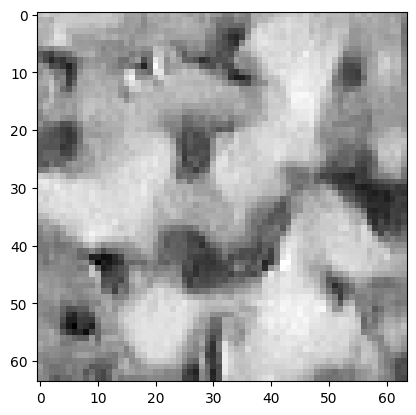

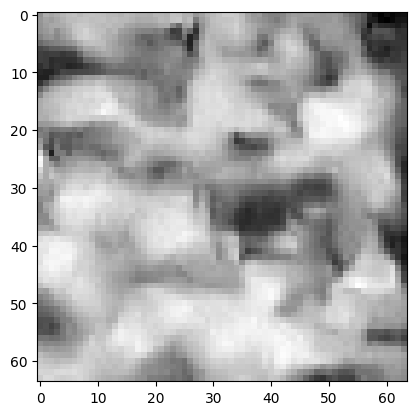

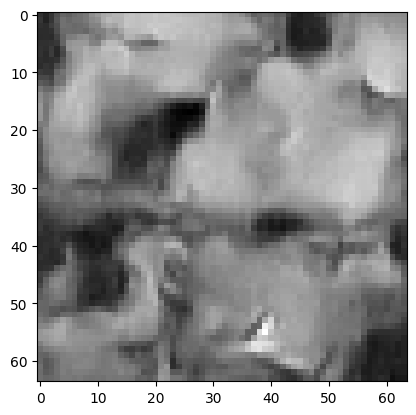

Epoch 202 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.04869354768787468
Epoch 203 : 


100%|██████████| 400/400 [00:19<00:00, 20.07it/s]


loss 0.08058644946984087
Epoch 204 : 


100%|██████████| 400/400 [00:19<00:00, 20.26it/s]


loss 0.10448238890379855
Epoch 205 : 


100%|██████████| 400/400 [00:20<00:00, 19.86it/s]


loss 0.10398605425116536
Epoch 206 : 


100%|██████████| 400/400 [00:19<00:00, 20.58it/s]


loss 0.087811641051292
Epoch 207 : 


100%|██████████| 400/400 [00:20<00:00, 19.75it/s]


loss 0.08888496977425513
Epoch 208 : 


100%|██████████| 400/400 [00:19<00:00, 20.10it/s]


loss 0.0529688641747458
Epoch 209 : 


100%|██████████| 400/400 [00:20<00:00, 19.50it/s]


loss 0.06267792536346738
Epoch 210 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.06343701466186738
Epoch 211 : 


100%|██████████| 400/400 [00:19<00:00, 20.09it/s]


loss 0.07049398553798793
Epoch 212 : 


100%|██████████| 400/400 [00:20<00:00, 19.93it/s]


loss 0.08576397839800323
Epoch 213 : 


100%|██████████| 400/400 [00:19<00:00, 20.12it/s]


loss 0.19790971900972593
Epoch 214 : 


100%|██████████| 400/400 [00:19<00:00, 20.11it/s]


loss 0.0597030323931698
Epoch 215 : 


100%|██████████| 400/400 [00:19<00:00, 20.27it/s]


loss 0.045566332854167155
Epoch 216 : 


100%|██████████| 400/400 [00:19<00:00, 20.01it/s]


loss 0.04225055184917886
Epoch 217 : 


100%|██████████| 400/400 [00:19<00:00, 20.27it/s]


loss 0.10633535134554639
Epoch 218 : 


100%|██████████| 400/400 [00:20<00:00, 19.31it/s]


loss 0.06702406260941773
Epoch 219 : 


100%|██████████| 400/400 [00:19<00:00, 20.11it/s]


loss 0.14835839197332928
Epoch 220 : 


100%|██████████| 400/400 [00:19<00:00, 20.03it/s]


loss 0.040900083732791206
Epoch 221 : 


100%|██████████| 400/400 [00:20<00:00, 19.36it/s]


loss 0.05824711018821142
torch.Size([3, 1, 64, 64])


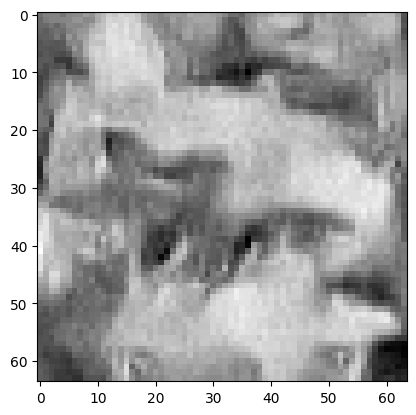

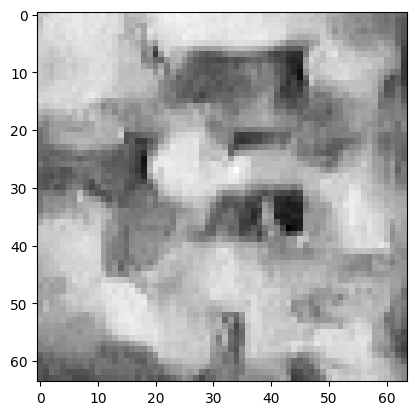

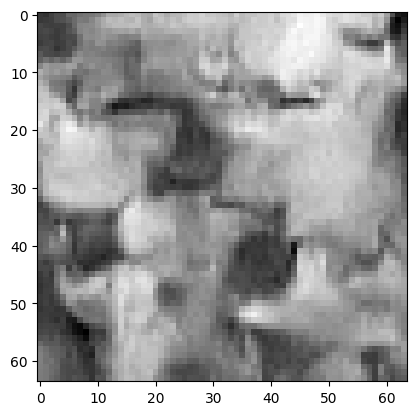

Epoch 222 : 


100%|██████████| 400/400 [00:20<00:00, 19.89it/s]


loss 0.07903746271803376
Epoch 223 : 


100%|██████████| 400/400 [00:19<00:00, 20.40it/s]


loss 0.1006998450704247
Epoch 224 : 


100%|██████████| 400/400 [00:19<00:00, 20.78it/s]


loss 0.05399393032744079
Epoch 225 : 


100%|██████████| 400/400 [00:19<00:00, 20.20it/s]


loss 0.052918181779792316
Epoch 226 : 


100%|██████████| 400/400 [00:20<00:00, 19.93it/s]


loss 0.02197207441776009
Epoch 227 : 


100%|██████████| 400/400 [00:19<00:00, 20.50it/s]


loss 0.10370557436043484
Epoch 228 : 


100%|██████████| 400/400 [00:19<00:00, 20.55it/s]


loss 0.03906394577928389
Epoch 229 : 


100%|██████████| 400/400 [00:19<00:00, 20.05it/s]


loss 0.1082782591903719
Epoch 230 : 


100%|██████████| 400/400 [00:19<00:00, 20.19it/s]


loss 0.047458386860323096
Epoch 231 : 


100%|██████████| 400/400 [00:19<00:00, 20.52it/s]


loss 0.03081476295123276
Epoch 232 : 


100%|██████████| 400/400 [00:19<00:00, 20.77it/s]


loss 0.056727376849425144
Epoch 233 : 


100%|██████████| 400/400 [00:18<00:00, 21.36it/s]


loss 0.04764482269310691
Epoch 234 : 


100%|██████████| 400/400 [00:18<00:00, 21.07it/s]


loss 0.1136041910251521
Epoch 235 : 


100%|██████████| 400/400 [00:19<00:00, 20.40it/s]


loss 0.08470160303333739
Epoch 236 : 


100%|██████████| 400/400 [00:19<00:00, 20.29it/s]


loss 0.1454881815764449
Epoch 237 : 


100%|██████████| 400/400 [00:19<00:00, 20.58it/s]


loss 0.06576460734074037
Epoch 238 : 


100%|██████████| 400/400 [00:19<00:00, 20.53it/s]


loss 0.07876973049310748
Epoch 239 : 


100%|██████████| 400/400 [00:19<00:00, 20.13it/s]


loss 0.042422251230231044
Epoch 240 : 


100%|██████████| 400/400 [00:19<00:00, 20.97it/s]


loss 0.042476720140242376
Epoch 241 : 


100%|██████████| 400/400 [00:18<00:00, 21.11it/s]


loss 0.05473439818668063
torch.Size([3, 1, 64, 64])


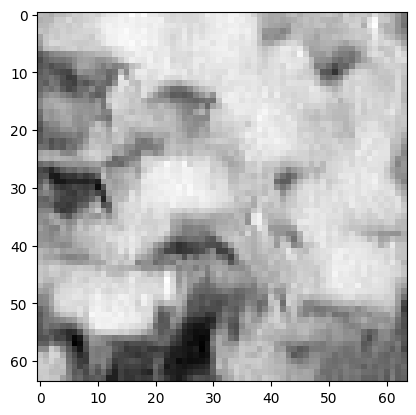

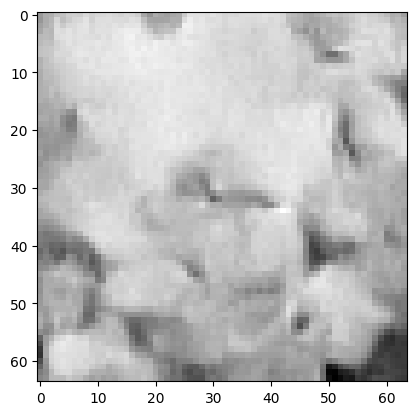

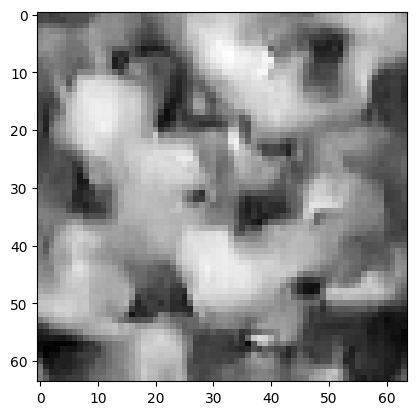

Epoch 242 : 


100%|██████████| 400/400 [00:19<00:00, 20.49it/s]


loss 0.055352938816899504
Epoch 243 : 


100%|██████████| 400/400 [00:19<00:00, 20.49it/s]


loss 0.06788046185322713
Epoch 244 : 


100%|██████████| 400/400 [00:20<00:00, 19.47it/s]


loss 0.04835670656122861
Epoch 245 : 


100%|██████████| 400/400 [00:20<00:00, 19.81it/s]


loss 0.06883207628611424
Epoch 246 : 


100%|██████████| 400/400 [00:19<00:00, 20.57it/s]


loss 0.03339743703025003
Epoch 247 : 


100%|██████████| 400/400 [00:19<00:00, 20.26it/s]


loss 0.057112991659790134
Epoch 248 : 


100%|██████████| 400/400 [00:19<00:00, 20.52it/s]


loss 0.058740232140124124
Epoch 249 : 


100%|██████████| 400/400 [00:20<00:00, 19.79it/s]


loss 0.0684479380643565
Epoch 250 : 


100%|██████████| 400/400 [00:19<00:00, 20.32it/s]


loss 0.07607020632630235
Epoch 251 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.05170847982678749
Epoch 252 : 


100%|██████████| 400/400 [00:20<00:00, 19.73it/s]


loss 0.05313999429833184
Epoch 253 : 


100%|██████████| 400/400 [00:20<00:00, 19.88it/s]


loss 0.06688011523612522
Epoch 254 : 


100%|██████████| 400/400 [00:19<00:00, 20.23it/s]


loss 0.12142520988191062
Epoch 255 : 


100%|██████████| 400/400 [00:20<00:00, 19.92it/s]


loss 0.05207495325744101
Epoch 256 : 


100%|██████████| 400/400 [00:20<00:00, 19.45it/s]


loss 0.09864825587739494
Epoch 257 : 


100%|██████████| 400/400 [00:19<00:00, 20.69it/s]


loss 0.05396099926263805
Epoch 258 : 


100%|██████████| 400/400 [00:20<00:00, 19.83it/s]


loss 0.047413035942657944
Epoch 259 : 


100%|██████████| 400/400 [00:19<00:00, 20.04it/s]


loss 0.06696343886543964
Epoch 260 : 


100%|██████████| 400/400 [00:19<00:00, 20.18it/s]


loss 0.06793562546167695
Epoch 261 : 


100%|██████████| 400/400 [00:20<00:00, 19.75it/s]


loss 0.05522889982113096
torch.Size([3, 1, 64, 64])


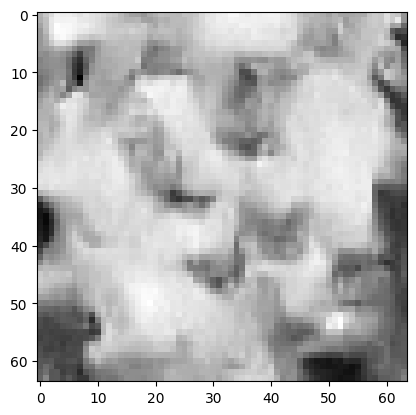

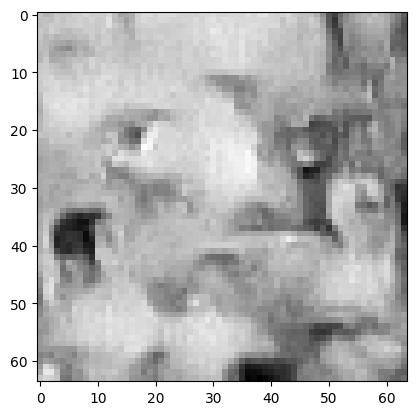

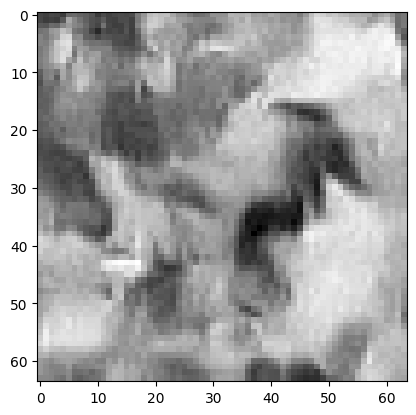

Epoch 262 : 


100%|██████████| 400/400 [00:20<00:00, 19.90it/s]


loss 0.12911738116526944
Epoch 263 : 


100%|██████████| 400/400 [00:19<00:00, 20.61it/s]


loss 0.11790078301012474
Epoch 264 : 


100%|██████████| 400/400 [00:20<00:00, 19.95it/s]


loss 0.12403906790903074
Epoch 265 : 


100%|██████████| 400/400 [00:19<00:00, 20.64it/s]


loss 0.12099127061169149
Epoch 266 : 


100%|██████████| 400/400 [00:20<00:00, 19.65it/s]


loss 0.057173217668551886
Epoch 267 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.08534867020866951
Epoch 268 : 


100%|██████████| 400/400 [00:19<00:00, 20.84it/s]


loss 0.17394539443207635
Epoch 269 : 


100%|██████████| 400/400 [00:20<00:00, 19.95it/s]


loss 0.062321285015368336
Epoch 270 : 


100%|██████████| 400/400 [00:19<00:00, 20.18it/s]


loss 0.06394783158349815
Epoch 271 : 


100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


loss 0.051105623300681954
Epoch 272 : 


100%|██████████| 400/400 [00:20<00:00, 19.43it/s]


loss 0.09368467007249973
Epoch 273 : 


100%|██████████| 400/400 [00:19<00:00, 20.41it/s]


loss 0.06522127155268981
Epoch 274 : 


100%|██████████| 400/400 [00:19<00:00, 20.41it/s]


loss 0.12830846227605613
Epoch 275 : 


100%|██████████| 400/400 [00:20<00:00, 19.76it/s]


loss 0.054525607081570435
Epoch 276 : 


100%|██████████| 400/400 [00:19<00:00, 20.17it/s]


loss 0.05969084650238662
Epoch 277 : 


100%|██████████| 400/400 [00:21<00:00, 19.03it/s]


loss 0.06762548808862041
Epoch 278 : 


100%|██████████| 400/400 [00:20<00:00, 19.90it/s]


loss 0.0844453549524034
Epoch 279 : 


100%|██████████| 400/400 [00:19<00:00, 20.17it/s]


loss 0.05292128063662781
Epoch 280 : 


100%|██████████| 400/400 [00:21<00:00, 18.88it/s]


loss 0.05326201594955389
Epoch 281 : 


100%|██████████| 400/400 [00:19<00:00, 20.09it/s]


loss 0.04196172453836523
torch.Size([3, 1, 64, 64])


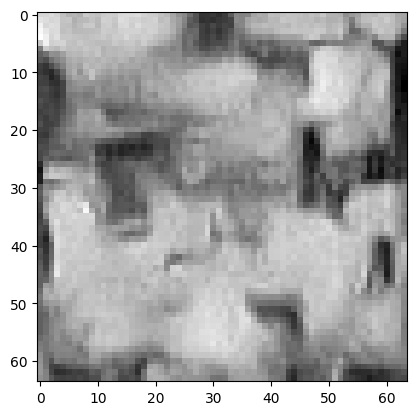

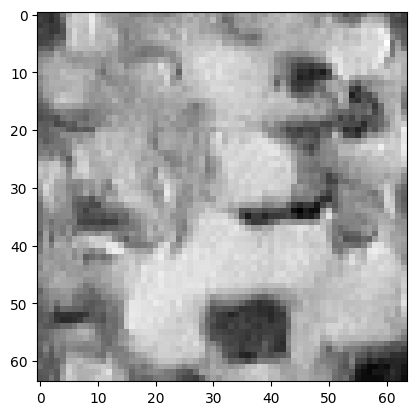

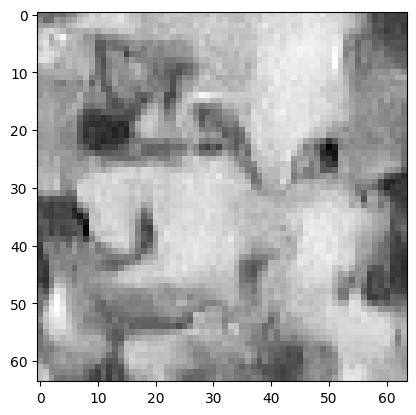

Epoch 282 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.07855149646433479
Epoch 283 : 


100%|██████████| 400/400 [00:19<00:00, 20.46it/s]


loss 0.08917135155546198
Epoch 284 : 


100%|██████████| 400/400 [00:20<00:00, 19.61it/s]


loss 0.1296797631810826
Epoch 285 : 


100%|██████████| 400/400 [00:20<00:00, 19.98it/s]


loss 0.08252298143599834
Epoch 286 : 


100%|██████████| 400/400 [00:19<00:00, 20.40it/s]


loss 0.06638164158472604
Epoch 287 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.07042243429868317
Epoch 288 : 


100%|██████████| 400/400 [00:20<00:00, 19.34it/s]


loss 0.0550070541765137
Epoch 289 : 


100%|██████████| 400/400 [00:20<00:00, 19.63it/s]


loss 0.08566207873784337
Epoch 290 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.041635037906619134
Epoch 291 : 


100%|██████████| 400/400 [00:19<00:00, 20.71it/s]


loss 0.06446805031248458
Epoch 292 : 


100%|██████████| 400/400 [00:19<00:00, 20.83it/s]


loss 0.06335502757046652
Epoch 293 : 


100%|██████████| 400/400 [00:20<00:00, 19.58it/s]


loss 0.053892718603216754
Epoch 294 : 


100%|██████████| 400/400 [00:20<00:00, 19.65it/s]


loss 0.04280840149718376
Epoch 295 : 


100%|██████████| 400/400 [00:19<00:00, 20.23it/s]


loss 0.10308624977531687
Epoch 296 : 


100%|██████████| 400/400 [00:20<00:00, 19.38it/s]


loss 0.08581564125775024
Epoch 297 : 


100%|██████████| 400/400 [00:20<00:00, 19.55it/s]


loss 0.0873091609559272
Epoch 298 : 


100%|██████████| 400/400 [00:20<00:00, 19.82it/s]


loss 0.05928714851756206
Epoch 299 : 


100%|██████████| 400/400 [00:19<00:00, 20.48it/s]


loss 0.14222547399922628
Epoch 300 : 


100%|██████████| 400/400 [00:20<00:00, 19.79it/s]


loss 0.10799226980474788
Epoch 301 : 


100%|██████████| 400/400 [00:19<00:00, 20.02it/s]


loss 0.05462146749198206
torch.Size([3, 1, 64, 64])


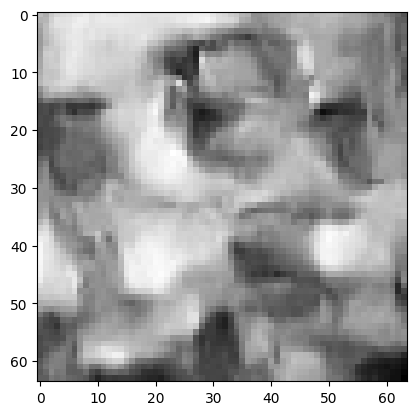

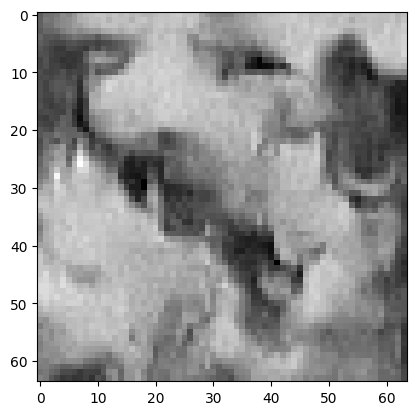

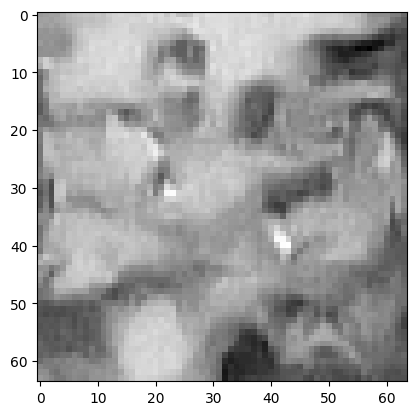

Epoch 302 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.07163049060355925
Epoch 303 : 


100%|██████████| 400/400 [00:19<00:00, 20.16it/s]


loss 0.11050609372591824
Epoch 304 : 


100%|██████████| 400/400 [00:19<00:00, 20.38it/s]


loss 0.061137600038760724
Epoch 305 : 


100%|██████████| 400/400 [00:19<00:00, 20.10it/s]


loss 0.031598546044441074
Epoch 306 : 


100%|██████████| 400/400 [00:19<00:00, 20.11it/s]


loss 0.05944671395946315
Epoch 307 : 


100%|██████████| 400/400 [00:19<00:00, 20.56it/s]


loss 0.06355198945276883
Epoch 308 : 


100%|██████████| 400/400 [00:19<00:00, 20.40it/s]


loss 0.051447219719087264
Epoch 309 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.1313490105356758
Epoch 310 : 


100%|██████████| 400/400 [00:20<00:00, 19.95it/s]


loss 0.1738797742391785
Epoch 311 : 


100%|██████████| 400/400 [00:19<00:00, 20.40it/s]


loss 0.07165320357956118
Epoch 312 : 


100%|██████████| 400/400 [00:18<00:00, 21.45it/s]


loss 0.06914519155185245
Epoch 313 : 


100%|██████████| 400/400 [00:21<00:00, 18.93it/s]


loss 0.06574744801607964
Epoch 314 : 


100%|██████████| 400/400 [00:19<00:00, 20.55it/s]


loss 0.07529837429865659
Epoch 315 : 


100%|██████████| 400/400 [00:19<00:00, 20.09it/s]


loss 0.08708838696652622
Epoch 316 : 


100%|██████████| 400/400 [00:19<00:00, 20.06it/s]


loss 0.02973825191033741
Epoch 317 : 


100%|██████████| 400/400 [00:19<00:00, 20.24it/s]


loss 0.156360703042142
Epoch 318 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.0780559387957794
Epoch 319 : 


100%|██████████| 400/400 [00:20<00:00, 19.85it/s]


loss 0.03516057824716663
Epoch 320 : 


100%|██████████| 400/400 [00:20<00:00, 19.40it/s]


loss 0.10847064997087671
Epoch 321 : 


100%|██████████| 400/400 [00:19<00:00, 20.32it/s]


loss 0.06203056270259794
torch.Size([3, 1, 64, 64])


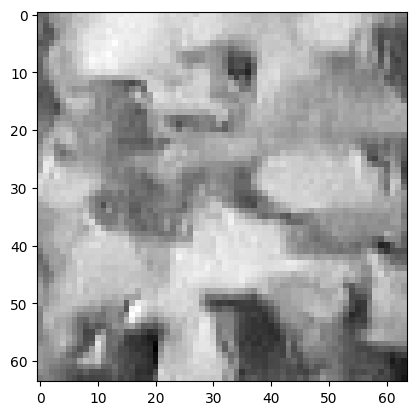

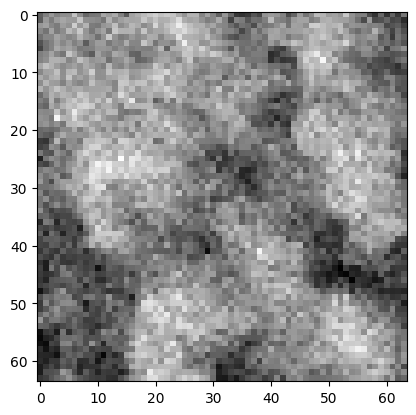

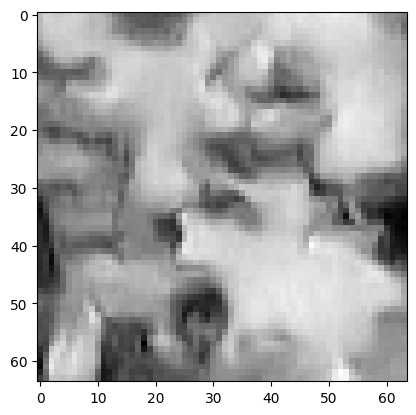

Epoch 322 : 


100%|██████████| 400/400 [00:19<00:00, 20.49it/s]


loss 0.0891726806164189
Epoch 323 : 


100%|██████████| 400/400 [00:20<00:00, 19.43it/s]


loss 0.06001279668194991
Epoch 324 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.13920185035692273
Epoch 325 : 


100%|██████████| 400/400 [00:19<00:00, 20.67it/s]


loss 0.03495597597191512
Epoch 326 : 


100%|██████████| 400/400 [00:19<00:00, 20.52it/s]


loss 0.0872673162333946
Epoch 327 : 


100%|██████████| 400/400 [00:19<00:00, 20.03it/s]


loss 0.04941593425516002
Epoch 328 : 


100%|██████████| 400/400 [00:20<00:00, 19.95it/s]


loss 0.09487059718041761
Epoch 329 : 


100%|██████████| 400/400 [00:19<00:00, 20.28it/s]


loss 0.051322299349983794
Epoch 330 : 


100%|██████████| 400/400 [00:19<00:00, 21.01it/s]


loss 0.09367660811268215
Epoch 331 : 


100%|██████████| 400/400 [00:20<00:00, 19.59it/s]


loss 0.07224914016407155
Epoch 332 : 


100%|██████████| 400/400 [00:19<00:00, 20.44it/s]


loss 0.0866012406943415
Epoch 333 : 


100%|██████████| 400/400 [00:19<00:00, 20.83it/s]


loss 0.0574512913550642
Epoch 334 : 


100%|██████████| 400/400 [00:20<00:00, 19.77it/s]


loss 0.20617349919956424
Epoch 335 : 


100%|██████████| 400/400 [00:19<00:00, 20.29it/s]


loss 0.08837867081410068
Epoch 336 : 


100%|██████████| 400/400 [00:18<00:00, 21.23it/s]


loss 0.08331153444264378
Epoch 337 : 


100%|██████████| 400/400 [00:18<00:00, 21.10it/s]


loss 0.07754183369687691
Epoch 338 : 


100%|██████████| 400/400 [00:19<00:00, 20.89it/s]


loss 0.08230918356828439
Epoch 339 : 


100%|██████████| 400/400 [00:19<00:00, 20.08it/s]


loss 0.06867079326195918
Epoch 340 : 


100%|██████████| 400/400 [00:19<00:00, 20.56it/s]


loss 0.10428137835216916
Epoch 341 : 


100%|██████████| 400/400 [00:19<00:00, 20.10it/s]


loss 0.04080242590072085
torch.Size([3, 1, 64, 64])


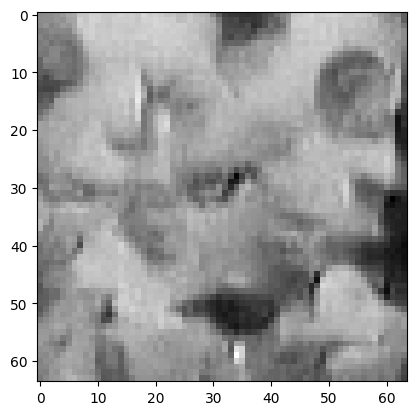

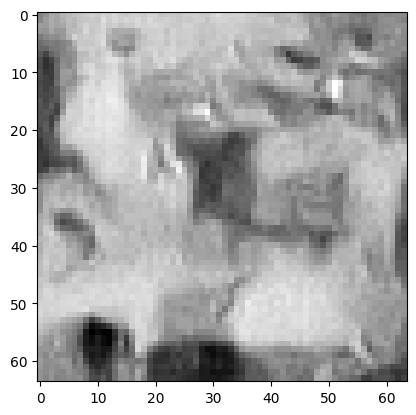

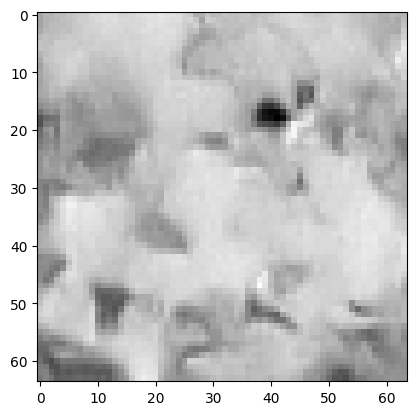

Epoch 342 : 


100%|██████████| 400/400 [00:19<00:00, 20.82it/s]


loss 0.05641470704646364
Epoch 343 : 


100%|██████████| 400/400 [00:19<00:00, 20.81it/s]


loss 0.05353130599432532
Epoch 344 : 


100%|██████████| 400/400 [00:20<00:00, 19.51it/s]


loss 0.05409958995343919
Epoch 345 : 


100%|██████████| 400/400 [00:19<00:00, 20.85it/s]


loss 0.1609267072731706
Epoch 346 : 


100%|██████████| 400/400 [00:19<00:00, 20.58it/s]


loss 0.13100690452418706
Epoch 347 : 


100%|██████████| 400/400 [00:19<00:00, 20.38it/s]


loss 0.05414937642512684
Epoch 348 : 


100%|██████████| 400/400 [00:20<00:00, 19.93it/s]


loss 0.054056054308023974
Epoch 349 : 


100%|██████████| 400/400 [00:20<00:00, 19.73it/s]


loss 0.02920236593007523
Epoch 350 : 


100%|██████████| 400/400 [00:20<00:00, 19.74it/s]


loss 0.05553193590392543
Epoch 351 : 


100%|██████████| 400/400 [00:18<00:00, 21.13it/s]


loss 0.08286822501459061
Epoch 352 : 


100%|██████████| 400/400 [00:19<00:00, 20.55it/s]


loss 0.08191299346153164
Epoch 353 : 


100%|██████████| 400/400 [00:19<00:00, 20.52it/s]


loss 0.05103864089270973
Epoch 354 : 


100%|██████████| 400/400 [00:20<00:00, 19.30it/s]


loss 0.054571603586918614
Epoch 355 : 


100%|██████████| 400/400 [00:19<00:00, 20.57it/s]


loss 0.06931503851725569
Epoch 356 : 


100%|██████████| 400/400 [00:19<00:00, 20.51it/s]


loss 0.07633439394549413
Epoch 357 : 


100%|██████████| 400/400 [00:19<00:00, 20.22it/s]


loss 0.1341755636738459
Epoch 358 : 


100%|██████████| 400/400 [00:19<00:00, 20.33it/s]


loss 0.059693980972286745
Epoch 359 : 


100%|██████████| 400/400 [00:19<00:00, 20.85it/s]


loss 0.07492910482154841
Epoch 360 : 


100%|██████████| 400/400 [00:19<00:00, 20.31it/s]


loss 0.13592295917558633
Epoch 361 : 


100%|██████████| 400/400 [00:19<00:00, 20.52it/s]


loss 0.10404795253873572
torch.Size([3, 1, 64, 64])


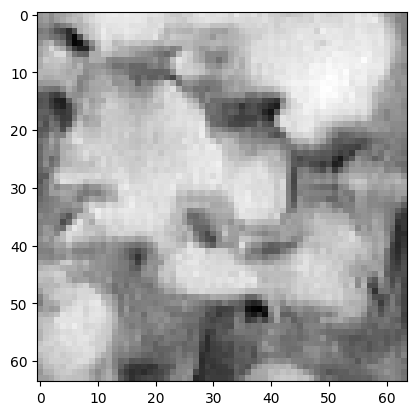

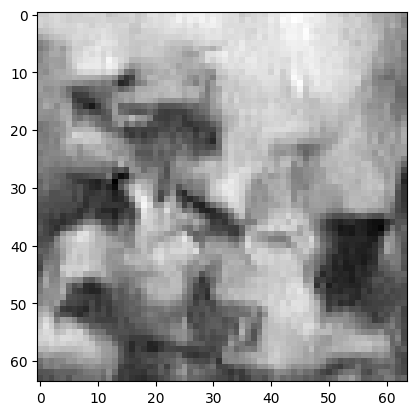

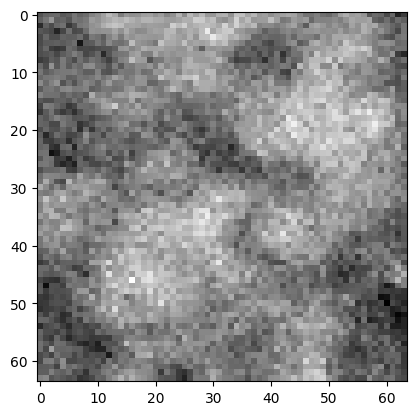

Epoch 362 : 


100%|██████████| 400/400 [00:19<00:00, 20.57it/s]


loss 0.05849931562059455
Epoch 363 : 


100%|██████████| 400/400 [00:19<00:00, 20.07it/s]


loss 0.05667404477403663
Epoch 364 : 


100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


loss 0.07021784487732204
Epoch 365 : 


100%|██████████| 400/400 [00:20<00:00, 19.83it/s]


loss 0.09898310980609272
Epoch 366 : 


100%|██████████| 400/400 [00:20<00:00, 19.92it/s]


loss 0.07916863071749267
Epoch 367 : 


100%|██████████| 400/400 [00:19<00:00, 20.32it/s]


loss 0.04682078999137123
Epoch 368 : 


100%|██████████| 400/400 [00:20<00:00, 19.46it/s]


loss 0.10991256710138862
Epoch 369 : 


100%|██████████| 400/400 [00:19<00:00, 20.11it/s]


loss 0.09418032979216827
Epoch 370 : 


100%|██████████| 400/400 [00:20<00:00, 19.98it/s]


loss 0.03819033847365675
Epoch 371 : 


100%|██████████| 400/400 [00:19<00:00, 20.07it/s]


loss 0.04706532199134555
Epoch 372 : 


100%|██████████| 400/400 [00:19<00:00, 20.45it/s]


loss 0.09902421338215904
Epoch 373 : 


100%|██████████| 400/400 [00:18<00:00, 21.32it/s]


loss 0.05701763320307991
Epoch 374 : 


100%|██████████| 400/400 [00:20<00:00, 19.55it/s]


loss 0.04072487012085093
Epoch 375 : 


100%|██████████| 400/400 [00:19<00:00, 20.93it/s]


loss 0.06289828177955337
Epoch 376 : 


100%|██████████| 400/400 [00:18<00:00, 21.12it/s]


loss 0.1258067826001032
Epoch 377 : 


100%|██████████| 400/400 [00:20<00:00, 19.73it/s]


loss 0.06794973152118554
Epoch 378 : 


100%|██████████| 400/400 [00:20<00:00, 19.70it/s]


loss 0.07773500196618673
Epoch 379 : 


100%|██████████| 400/400 [00:19<00:00, 21.02it/s]


loss 0.07410520088027112
Epoch 380 : 


100%|██████████| 400/400 [00:19<00:00, 20.78it/s]


loss 0.07209191831263224
Epoch 381 : 


100%|██████████| 400/400 [00:19<00:00, 20.90it/s]


loss 0.03888677963636676
torch.Size([3, 1, 64, 64])


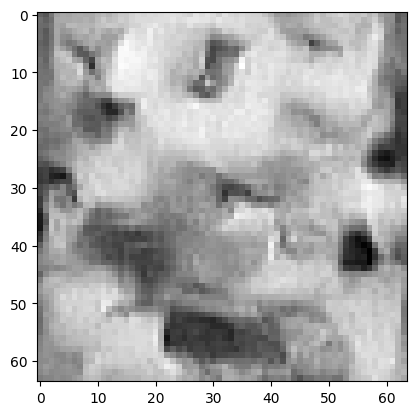

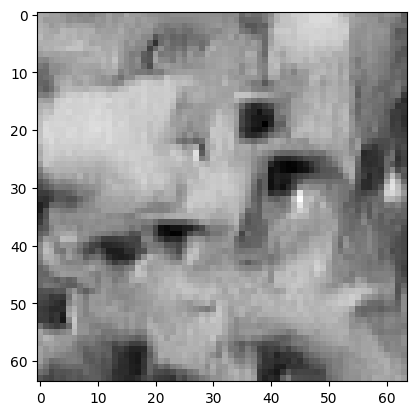

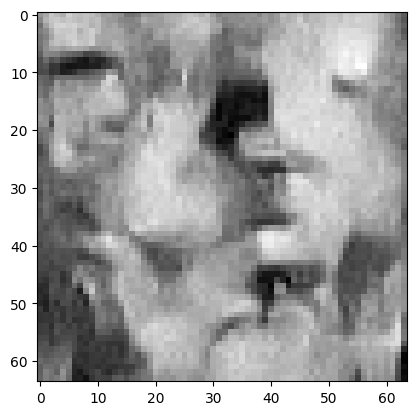

Epoch 382 : 


100%|██████████| 400/400 [00:18<00:00, 21.21it/s]


loss 0.09159163658408212
Epoch 383 : 


100%|██████████| 400/400 [00:19<00:00, 20.85it/s]


loss 0.023141375491310637
Epoch 384 : 


100%|██████████| 400/400 [00:19<00:00, 20.61it/s]


loss 0.0376100307756501
Epoch 385 : 


100%|██████████| 400/400 [00:19<00:00, 21.04it/s]


loss 0.08830705528469018
Epoch 386 : 


100%|██████████| 400/400 [00:19<00:00, 20.56it/s]


loss 0.06898196037411779
Epoch 387 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.11092067448152895
Epoch 388 : 


100%|██████████| 400/400 [00:19<00:00, 20.21it/s]


loss 0.05602218333476349
Epoch 389 : 


100%|██████████| 400/400 [00:19<00:00, 20.41it/s]


loss 0.03200156595858859
Epoch 390 : 


100%|██████████| 400/400 [00:19<00:00, 20.98it/s]


loss 0.055666420528071976
Epoch 391 : 


100%|██████████| 400/400 [00:19<00:00, 20.59it/s]


loss 0.07599780618075047
Epoch 392 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.03533557227454843
Epoch 393 : 


100%|██████████| 400/400 [00:18<00:00, 21.06it/s]


loss 0.09190564064027704
Epoch 394 : 


100%|██████████| 400/400 [00:18<00:00, 21.27it/s]


loss 0.06078366664324092
Epoch 395 : 


100%|██████████| 400/400 [00:19<00:00, 20.62it/s]


loss 0.07046632854454016
Epoch 396 : 


100%|██████████| 400/400 [00:20<00:00, 19.76it/s]


loss 0.04035970940813478
Epoch 397 : 


100%|██████████| 400/400 [00:18<00:00, 21.10it/s]


loss 0.048211901002727216
Epoch 398 : 


100%|██████████| 400/400 [00:19<00:00, 20.67it/s]


loss 0.08447654626219603
Epoch 399 : 


100%|██████████| 400/400 [00:19<00:00, 21.05it/s]


loss 0.0514653698907517
Epoch 400 : 


100%|██████████| 400/400 [00:19<00:00, 20.48it/s]


loss 0.04645756190556384
Epoch 401 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.07088230729175762
torch.Size([3, 1, 64, 64])


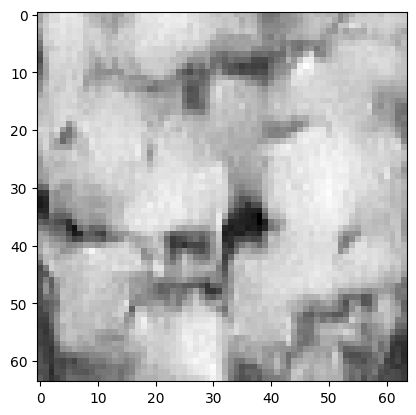

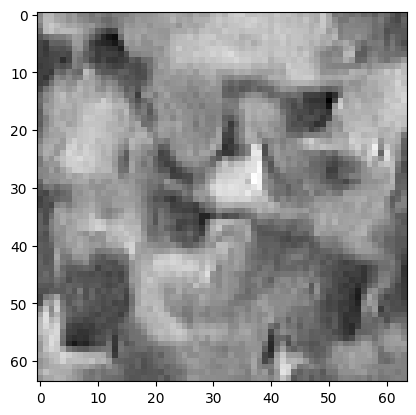

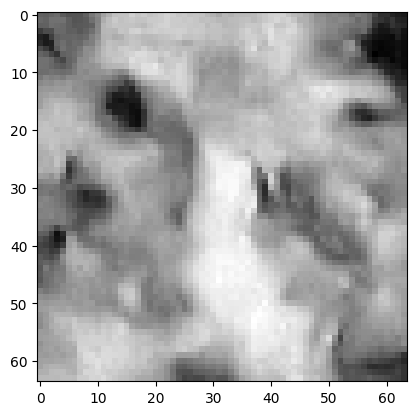

Epoch 402 : 


100%|██████████| 400/400 [00:18<00:00, 21.13it/s]


loss 0.04976164905810799
Epoch 403 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.1034825670407559
Epoch 404 : 


100%|██████████| 400/400 [00:19<00:00, 20.75it/s]


loss 0.1381378766421029
Epoch 405 : 


100%|██████████| 400/400 [00:19<00:00, 20.03it/s]


loss 0.1036983716799312
Epoch 406 : 


100%|██████████| 400/400 [00:19<00:00, 20.57it/s]


loss 0.04620241900682188
Epoch 407 : 


100%|██████████| 400/400 [00:18<00:00, 21.14it/s]


loss 0.07450846128457746
Epoch 408 : 


100%|██████████| 400/400 [00:19<00:00, 20.51it/s]


loss 0.04082037720182967
Epoch 409 : 


100%|██████████| 400/400 [00:19<00:00, 20.10it/s]


loss 0.059950465267720215
Epoch 410 : 


100%|██████████| 400/400 [00:20<00:00, 19.70it/s]


loss 0.08077748896210453
Epoch 411 : 


100%|██████████| 400/400 [00:19<00:00, 20.90it/s]


loss 0.0603985803155382
Epoch 412 : 


100%|██████████| 400/400 [00:19<00:00, 20.08it/s]


loss 0.12544901204433787
Epoch 413 : 


100%|██████████| 400/400 [00:19<00:00, 20.49it/s]


loss 0.04729733149736367
Epoch 414 : 


100%|██████████| 400/400 [00:20<00:00, 19.78it/s]


loss 0.049267826231342376
Epoch 415 : 


100%|██████████| 400/400 [00:20<00:00, 19.81it/s]


loss 0.0646786115976576
Epoch 416 : 


100%|██████████| 400/400 [00:19<00:00, 20.62it/s]


loss 0.03383756993753779
Epoch 417 : 


100%|██████████| 400/400 [00:19<00:00, 20.80it/s]


loss 0.09374812879002693
Epoch 418 : 


100%|██████████| 400/400 [00:19<00:00, 20.57it/s]


loss 0.054458644949327895
Epoch 419 : 


100%|██████████| 400/400 [00:19<00:00, 20.20it/s]


loss 0.1149569724465703
Epoch 420 : 


100%|██████████| 400/400 [00:19<00:00, 20.81it/s]


loss 0.06302821612585388
Epoch 421 : 


100%|██████████| 400/400 [00:19<00:00, 20.80it/s]


loss 0.08857481646818685
torch.Size([3, 1, 64, 64])


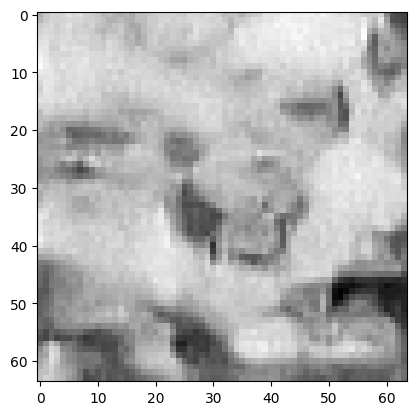

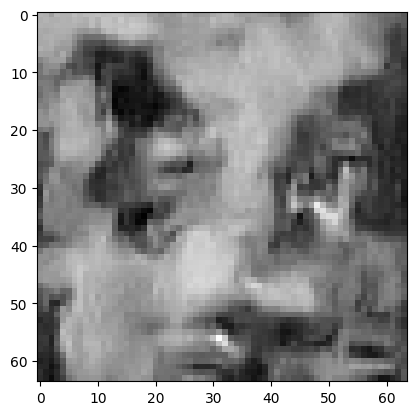

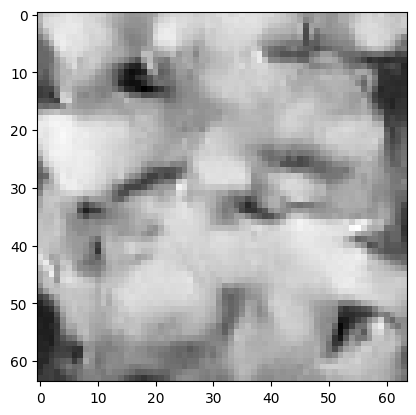

Epoch 422 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.11692376630618584
Epoch 423 : 


100%|██████████| 400/400 [00:21<00:00, 18.68it/s]


loss 0.08212161248892506
Epoch 424 : 


100%|██████████| 400/400 [00:20<00:00, 19.89it/s]


loss 0.061797053912039775
Epoch 425 : 


100%|██████████| 400/400 [00:19<00:00, 20.91it/s]


loss 0.14190975030605765
Epoch 426 : 


100%|██████████| 400/400 [00:19<00:00, 20.83it/s]


loss 0.10794956901535972
Epoch 427 : 


100%|██████████| 400/400 [00:19<00:00, 20.35it/s]


loss 0.08997314162898701
Epoch 428 : 


100%|██████████| 400/400 [00:19<00:00, 20.26it/s]


loss 0.05278620284285581
Epoch 429 : 


100%|██████████| 400/400 [00:19<00:00, 20.54it/s]


loss 0.09323697186887281
Epoch 430 : 


100%|██████████| 400/400 [00:19<00:00, 20.60it/s]


loss 0.03231426858329538
Epoch 431 : 


100%|██████████| 400/400 [00:19<00:00, 20.79it/s]


loss 0.13544817735600223
Epoch 432 : 


100%|██████████| 400/400 [00:19<00:00, 20.95it/s]


loss 0.056013934282023815
Epoch 433 : 


100%|██████████| 400/400 [00:19<00:00, 20.55it/s]


loss 0.07209297665099665
Epoch 434 : 


100%|██████████| 400/400 [00:18<00:00, 21.49it/s]


loss 0.12611509762228496
Epoch 435 : 


100%|██████████| 400/400 [00:19<00:00, 20.09it/s]


loss 0.07629855934394542
Epoch 436 : 


100%|██████████| 400/400 [00:19<00:00, 20.87it/s]


loss 0.05140686660312263
Epoch 437 : 


100%|██████████| 400/400 [00:20<00:00, 19.64it/s]


loss 0.029599580484968267
Epoch 438 : 


100%|██████████| 400/400 [00:20<00:00, 19.58it/s]


loss 0.09647695923442876
Epoch 439 : 


100%|██████████| 400/400 [00:19<00:00, 20.57it/s]


loss 0.0966840800043154
Epoch 440 : 


100%|██████████| 400/400 [00:19<00:00, 20.88it/s]


loss 0.12687204452902312
Epoch 441 : 


100%|██████████| 400/400 [00:19<00:00, 20.27it/s]


loss 0.06957741457374461
torch.Size([3, 1, 64, 64])


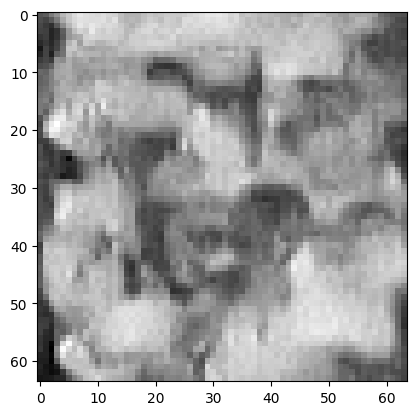

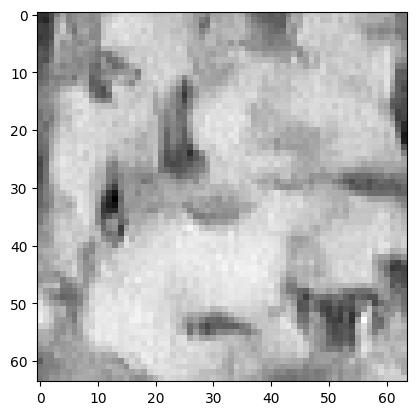

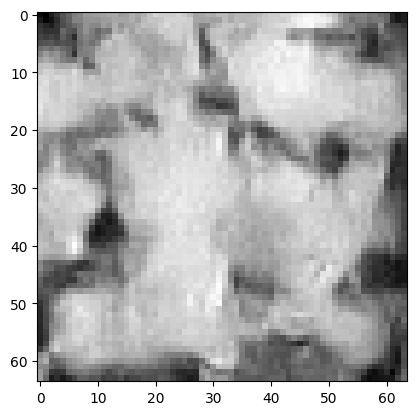

Epoch 442 : 


100%|██████████| 400/400 [00:19<00:00, 20.62it/s]


loss 0.05198456247902702
Epoch 443 : 


100%|██████████| 400/400 [00:20<00:00, 19.34it/s]


loss 0.023420596246323495
Epoch 444 : 


100%|██████████| 400/400 [00:18<00:00, 21.15it/s]


loss 0.10537986569594314
Epoch 445 : 


100%|██████████| 400/400 [00:19<00:00, 20.72it/s]


loss 0.042134855127515726
Epoch 446 : 


100%|██████████| 400/400 [00:19<00:00, 21.01it/s]


loss 0.0517934991578243
Epoch 447 : 


100%|██████████| 400/400 [00:18<00:00, 21.56it/s]


loss 0.08568690334120913
Epoch 448 : 


100%|██████████| 400/400 [00:19<00:00, 20.63it/s]


loss 0.04999024763059908
Epoch 449 : 


100%|██████████| 400/400 [00:20<00:00, 19.51it/s]


loss 0.0651341725526921
Epoch 450 : 


100%|██████████| 400/400 [00:19<00:00, 20.48it/s]


loss 0.10348330278777994
Epoch 451 : 


100%|██████████| 400/400 [00:20<00:00, 19.72it/s]


loss 0.0962492544080255
Epoch 452 : 


100%|██████████| 400/400 [00:19<00:00, 20.51it/s]


loss 0.06963891696016825
Epoch 453 : 


100%|██████████| 400/400 [00:19<00:00, 20.03it/s]


loss 0.20091439483565626
Epoch 454 : 


100%|██████████| 400/400 [00:20<00:00, 19.82it/s]


loss 0.1667312124253111
Epoch 455 : 


100%|██████████| 400/400 [00:20<00:00, 19.69it/s]


loss 0.04944435150162961
Epoch 456 : 


100%|██████████| 400/400 [00:19<00:00, 20.64it/s]


loss 0.07065246655222553
Epoch 457 : 


100%|██████████| 400/400 [00:19<00:00, 20.71it/s]


loss 0.0685359760762208
Epoch 458 : 


100%|██████████| 400/400 [00:19<00:00, 20.62it/s]


loss 0.05376181479385063
Epoch 459 : 


100%|██████████| 400/400 [00:19<00:00, 20.17it/s]


loss 0.0817325090971083
Epoch 460 : 


100%|██████████| 400/400 [00:20<00:00, 19.79it/s]


loss 0.06998293870578713
Epoch 461 : 


100%|██████████| 400/400 [00:19<00:00, 20.17it/s]


loss 0.046118850750130475
torch.Size([3, 1, 64, 64])


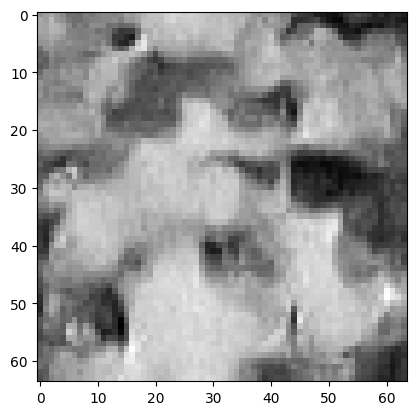

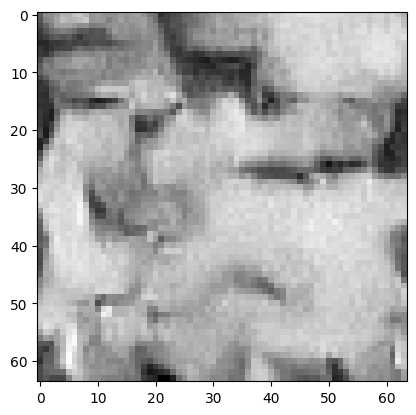

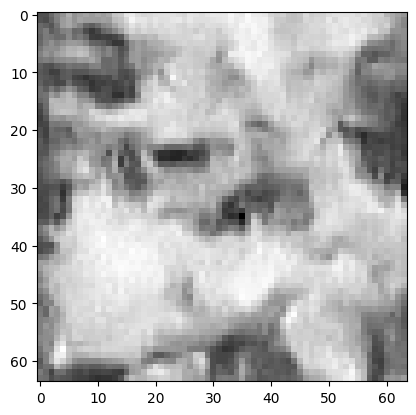

Epoch 462 : 


100%|██████████| 400/400 [00:19<00:00, 20.58it/s]


loss 0.07255659123056883
Epoch 463 : 


100%|██████████| 400/400 [00:19<00:00, 20.09it/s]


loss 0.05357467964054411
Epoch 464 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.04616478276572582
Epoch 465 : 


100%|██████████| 400/400 [00:19<00:00, 20.67it/s]


loss 0.08639015581353933
Epoch 466 : 


100%|██████████| 400/400 [00:20<00:00, 20.00it/s]


loss 0.06902402953093598
Epoch 467 : 


100%|██████████| 400/400 [00:19<00:00, 20.64it/s]


loss 0.11313499880843278
Epoch 468 : 


100%|██████████| 400/400 [00:19<00:00, 20.06it/s]


loss 0.08083689673337904
Epoch 469 : 


100%|██████████| 400/400 [00:18<00:00, 21.29it/s]


loss 0.06794803973956001
Epoch 470 : 


100%|██████████| 400/400 [00:19<00:00, 20.64it/s]


loss 0.0420381362471454
Epoch 471 : 


100%|██████████| 400/400 [00:19<00:00, 20.03it/s]


loss 0.04603284552905847
Epoch 472 : 


100%|██████████| 400/400 [00:19<00:00, 20.66it/s]


loss 0.07134739025788839
Epoch 473 : 


100%|██████████| 400/400 [00:19<00:00, 20.71it/s]


loss 0.06477566408664767
Epoch 474 : 


100%|██████████| 400/400 [00:19<00:00, 20.11it/s]


loss 0.06284953916335409
Epoch 475 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.11641777740779177
Epoch 476 : 


100%|██████████| 400/400 [00:19<00:00, 20.30it/s]


loss 0.11071444914346817
Epoch 477 : 


100%|██████████| 400/400 [00:18<00:00, 21.23it/s]


loss 0.08954209238314598
Epoch 478 : 


100%|██████████| 400/400 [00:20<00:00, 19.15it/s]


loss 0.05997226641246792
Epoch 479 : 


100%|██████████| 400/400 [00:19<00:00, 20.50it/s]


loss 0.10862025904789444
Epoch 480 : 


100%|██████████| 400/400 [00:18<00:00, 21.19it/s]


loss 0.1068600398309514
Epoch 481 : 


100%|██████████| 400/400 [00:18<00:00, 21.16it/s]


loss 0.08208528980320833
torch.Size([3, 1, 64, 64])


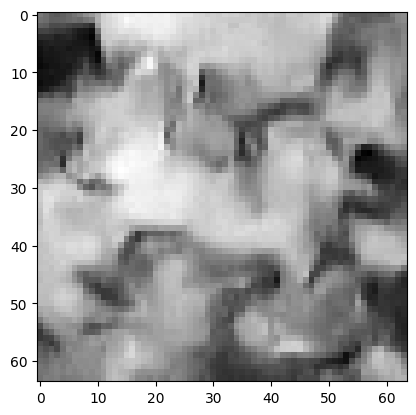

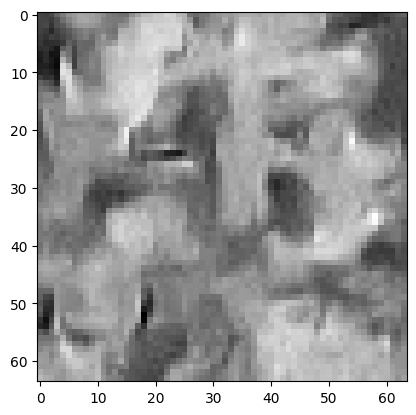

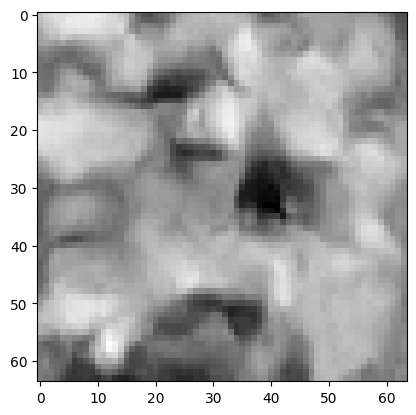

Epoch 482 : 


100%|██████████| 400/400 [00:19<00:00, 20.70it/s]


loss 0.1347660436943738
Epoch 483 : 


100%|██████████| 400/400 [00:19<00:00, 20.69it/s]


loss 0.07516979241930782
Epoch 484 : 


100%|██████████| 400/400 [00:19<00:00, 20.52it/s]


loss 0.0514318885758722
Epoch 485 : 


100%|██████████| 400/400 [00:19<00:00, 20.29it/s]


loss 0.06254349625432291
Epoch 486 : 


100%|██████████| 400/400 [00:19<00:00, 20.86it/s]


loss 0.049639321031762024
Epoch 487 : 


100%|██████████| 400/400 [00:19<00:00, 20.39it/s]


loss 0.09897329117717357
Epoch 488 : 


100%|██████████| 400/400 [00:20<00:00, 19.09it/s]


loss 0.0528050920655697
Epoch 489 : 


100%|██████████| 400/400 [00:19<00:00, 20.28it/s]


loss 0.03613789501533833
Epoch 490 : 


100%|██████████| 400/400 [00:19<00:00, 20.53it/s]


loss 0.047008546625735476
Epoch 491 : 


100%|██████████| 400/400 [00:19<00:00, 20.23it/s]


loss 0.03291761492035887
Epoch 492 : 


100%|██████████| 400/400 [00:19<00:00, 21.04it/s]


loss 0.03232898909297775
Epoch 493 : 


100%|██████████| 400/400 [00:18<00:00, 21.39it/s]


loss 0.028561730900346805
Epoch 494 : 


100%|██████████| 400/400 [00:20<00:00, 19.69it/s]


loss 0.14000892996718997
Epoch 495 : 


100%|██████████| 400/400 [00:21<00:00, 19.04it/s]


loss 0.04121432042748891
Epoch 496 : 


100%|██████████| 400/400 [00:19<00:00, 20.59it/s]


loss 0.03125837620786516
Epoch 497 : 


100%|██████████| 400/400 [00:19<00:00, 20.47it/s]


loss 0.060571286801434074
Epoch 498 : 


100%|██████████| 400/400 [00:19<00:00, 20.31it/s]


loss 0.11594590040581608
Epoch 499 : 


100%|██████████| 400/400 [00:19<00:00, 20.34it/s]


loss 0.07709487513303162


In [51]:
train_ddpm(500, 0.0001, 1, 0)